# Mining Grammars

## Imports

In [1]:
import src.utils as utils

In [2]:
import ast
import sys

In [3]:
import random

In [4]:
random.seed(0)

In [5]:
import json

## Subject Registry

We store all our subject programs in `program_src`.

In [6]:
program_src = {
    'calculator.py': utils.slurp('subjects/calculator.py'),
    'microjson.py': utils.slurp('subjects/microjson.py')
}

## Context Mangers

The context managers are probes inserted into the source code so that we know when execution enters and exits specific control flow structures such as conditionals and loops. Note that source code for these probes are not really a requirement. They can be inserted directly on binaries too, or even dynamically inserted using tools such as `dtrace`. For now, we make our life simple using AST editing.

In [7]:
%%writefile build/config.py
import urllib.parse # used for encoding meta chars.
# This is useful for parsers such as PEG where the argument
# is important as the name of the non-terminal.
ENCODE_ARGS = False
def encode_method_name(name, my_args):
    if not ENCODE_ARGS: return name
    if not my_args: return name
    # trick to convert args that are not of type str for later.
    if hasattr(my_args[0], 'tag'):
        name = "%s:%s" % (my_args[0].tag, name)
    else:
        return "%s(%s)" % (name, urllib.parse.quote('_'.join([str(i) for i in my_args])))

Writing build/config.py


### Method context
The `method__` context handles the assignment of method name, as well as storing the method stack.

In [8]:
%%writefile build/mimid_context.py
import ipynb.fs.full.x1_1_TrackAccess as taints
import config
def to_key(method, name, num):
    return '%s:%s_%s' % (method, name, num)

class method__:
    def __init__(self, name, args):
        if not taints.METHOD_NUM_STACK: return
        self.name = config.encode_method_name(name, args)
        self.method_name = self.name
        taints.trace_call(self.name)

    def __enter__(self):
        if not taints.METHOD_NUM_STACK: return
        self._old_name =  taints.trace_set_method(self.name)
        self.stack = []
        return self

    def __exit__(self, *args):
        if not taints.METHOD_NUM_STACK: return
        taints.trace_return()
        taints.trace_set_method(self._old_name)

Writing build/mimid_context.py


### Stack context

The stack context stores the current prefix and handles updating the stack that is stored at the method context. 

In [9]:
%%writefile -a build/mimid_context.py
class stack__:
    def __init__(self, name, num, method_i, can_empty):
        if not taints.METHOD_NUM_STACK: return
        self.stack = method_i.stack
        self.method_name = method_i.method_name
        self.can_empty = can_empty # * means yes. + means no, ? means to be determined
        self.name, self.num = name, num

    def __enter__(self):
        if not taints.METHOD_NUM_STACK: return
        if self.name in {'while'}:
            self.stack.append('loop_%d' % self.num)
        elif self.name in {'if'}:
            self.stack.append('if_%d' % self.num)
        else:
            assert False
        return self

    def __exit__(self, *args):
        if not taints.METHOD_NUM_STACK: return
        self.stack.pop()

Appending to build/mimid_context.py


### Scope context
The scope context correctly identifies when the control structure is entered into, and exited (in case of loops) and the alternative entered into (in case of if conditions).

In [10]:
%%writefile -a build/mimid_context.py
import json

def encode_name(method, ctrl, ctrl_id, alt_num, can_empty, stack):
    assert ctrl in {'while', 'if'}
    return '%s:%s_%s,%s %s#%s' % (method, ctrl, ctrl_id, alt_num, can_empty, json.dumps(stack))

class scope__:
    def __init__(self, alt, stack_i, method_i):
        if not taints.METHOD_NUM_STACK: return
        self.name, self.num, self.method, self.alt = stack_i.name, stack_i.num, stack_i.method_name, alt
        self.stack = stack_i.stack
        self.method_name = stack_i.method_name
        self.can_empty = stack_i.can_empty

    def __enter__(self):
        if not taints.METHOD_NUM_STACK: return
        if self.name in {'while'}:
            # we do not have to keep track of iteration id. We
            # instead recognize different parts of loops by compatible patterns
            pass
            #self.stack[-1] += 1
        elif self.name in {'if'}:
            pass
        else:
            assert False, self.name
        encoded_name = encode_name(self.method, self.name, self.num, self.alt, self.can_empty, self.stack)
        taints.trace_call(encoded_name)
        self._old_name = taints.trace_set_method(self.name)
        return self

    def __exit__(self, *args):
        if not taints.METHOD_NUM_STACK: return
        taints.trace_return()
        taints.trace_set_method(self._old_name)

Appending to build/mimid_context.py


## Rewriting the source to track control flow and taints.

We rewrite the methods so that method bodies are enclosed in a `method__` context manager, any `if`conditions and `while` loops (only `while` for now) are enclosed in an outer `stack__` and inner `scope__` context manager. This lets us track when the corresponding scopes are entered into and left.

### Rewriter

The `Rewriter` class handles inserting tracing probes into methods and control structures. Essentially, we insert a `with` scope for the method body, and a `with` scope outside both `while` and `if` scopes. Finally, we insert a `with` scope inside the `while` and `if` scopes. IMPORTANT: We only implement the `while` context. Similar should be implemented for the `for` context.

#### The method context wrapper

A few counters to provide unique identifiers for context managers. Essentially, we number each if and while that we see.

In [11]:
class Rewriter(ast.NodeTransformer):
    def init_counters(self):
        self.if_counter = 0
        self.while_counter = 0

The `methods[]` array is used to keep track of the current method stack during execution. Epsilon and NoEpsilon are simply constants that I use to indicate whether an IF or a Loop is nullable or not. If it is nullable, I mark it with Epsilon.

In [12]:
methods = []
Epsilon = '-'
NoEpsilon = '='

The `wrap_in_method()` generates a wrapper for method definitions.

In [13]:
class Rewriter(Rewriter):
    def wrap_in_method(self, body, args):
        method_name_expr = ast.Str(methods[-1])
        my_args = ast.List(args.args, ast.Load())
        args = [method_name_expr, my_args]
        scope_expr = ast.Call(func=ast.Name(id='method__', ctx=ast.Load()), args=args, keywords=[])
        return [ast.With(items=[ast.withitem(scope_expr, ast.Name(id='_method__'))], body=body)]

The method `visit_FunctionDef()` is the method rewriter that actually does the job.

In [14]:
class Rewriter(Rewriter):
    def visit_FunctionDef(self, tree_node):
        self.init_counters()
        methods.append(tree_node.name)
        self.generic_visit(tree_node)
        tree_node.body = self.wrap_in_method(tree_node.body, tree_node.args)
        return tree_node

The `rewrite_def()` method wraps the function definitions in scopes.

In [15]:
def rewrite_def(src):
    v = ast.fix_missing_locations(Rewriter().visit(ast.parse(src)))
    return ast.unparse(v)

We can use it as follows:

In [16]:
print(rewrite_def('\n'.join(program_src['calculator.py'].split('\n')[15:24])), 'calculator.py')

def parse_paren(s, i):
    with method__('parse_paren', [s, i]) as _method__:
        assert s[i] == '('
        (i, v) = parse_expr(s, i + 1)
        if s[i:] == '':
            raise Exception(s, i)
        assert s[i] == ')'
        return (i + 1, v) calculator.py


#### The stack wrapper

The method `wrap_in_outer()` adds a `with ..stack..()` context _outside_ the control structures. The stack is used to keep track of the current control structure stack for any character comparison made. Notice the `can_empty` parameter. This indicates that the particular structure is _nullable_. For `if` we can make the condition right away. For `while` we postpone the decision.

In [17]:
class Rewriter(Rewriter):
    def wrap_in_outer(self, name, can_empty, counter, node):
        name_expr = ast.Str(name)
        can_empty_expr = ast.Str(can_empty)
        counter_expr = ast.Num(counter)
        method_id = ast.Name(id='_method__')
        args = [name_expr, counter_expr, method_id, can_empty_expr]
        scope_expr = ast.Call(func=ast.Name(id='stack__', ctx=ast.Load()),
                args=args, keywords=[])
        return ast.With(
            items=[ast.withitem(scope_expr, ast.Name(id='%s_%d_stack__' % (name, counter)))], 
            body=[node])

#### The scope wrapper
The method `wrap_in_inner()` adds a `with ...scope..()` context immediately inside the control structure. For `while`, this means simply adding one `with ...scope..()` just before the first line. For `if`, this means adding one `with ...scope...()` each to each branch of the `if` condition.

In [18]:
class Rewriter(Rewriter):
    def wrap_in_inner(self, name, counter, val, body):
        val_expr = ast.Num(val)
        stack_iter = ast.Name(id='%s_%d_stack__' % (name, counter))
        method_id = ast.Name(id='_method__')
        args = [val_expr, stack_iter, method_id]
        scope_expr = ast.Call(func=ast.Name(id='scope__', ctx=ast.Load()),
                args=args, keywords=[])
        return [ast.With(
            items=[ast.withitem(scope_expr, ast.Name(id='%s_%d_%d_scope__' % (name, counter, val)))], 
            body=body)]

#### Rewriting `If` conditions

While rewriting if conditions, we have to take care of the cascading if conditions (`elsif`), which is represented as nested if conditions in AST. They do not require separate `stack` context, but only separate `scope` contexts.

In [19]:
class Rewriter(Rewriter):
    def process_if(self, tree_node, counter, val=None):
        if val is None: val = 0
        else: val += 1
        if_body = []
        self.generic_visit(tree_node.test)
        for node in tree_node.body:
            if_body.append(self.generic_visit(ast.Module(node)).body)
        tree_node.body = self.wrap_in_inner('if', counter, val, if_body)

        # else part.
        if len(tree_node.orelse) == 1 and isinstance(tree_node.orelse[0], ast.If):
            self.process_if(tree_node.orelse[0], counter, val)
        else:
            if tree_node.orelse:
                val += 1
                for node in tree_node.orelse: self.generic_visit(node)
                tree_node.orelse = self.wrap_in_inner('if', counter, val, tree_node.orelse)

While rewriting `if` conditions, we have to take care of the cascading `if` conditions, which is represented as nested `if` conditions in AST. We need to identify whether the cascading `if` conditions (`elsif`) have an empty `orelse` clause or not. If it has an empty `orelse`, then the entire set of `if` conditions may be excised, and still produce a valid value. Hence, it should be marked as optional. The `visit_If()` checks if the cascading `ifs` have an `orelse` or not.  

In [20]:
class Rewriter(Rewriter):
    def visit_If(self, tree_node):
        self.if_counter += 1
        counter = self.if_counter
        #is it empty
        start = tree_node
        while start:
            if isinstance(start, ast.If):
                if not start.orelse:
                    start = None
                elif len(start.orelse) == 1:
                    start = start.orelse[0]
                else:
                    break
            else:
                break
        self.process_if(tree_node, counter=self.if_counter)
        can_empty = NoEpsilon if start else Epsilon  # NoEpsilon for + and Epsilon for *
        return self.wrap_in_outer('if', can_empty, counter, tree_node)

#### Rewriting `while` loops

Rewriting while loops are simple. We wrap them in `stack` and `scope` contexts. We do not implement the `orelse` feature yet.

In [21]:
class Rewriter(Rewriter):
    def visit_While(self, tree_node):
        self.generic_visit(tree_node)
        self.while_counter += 1
        counter = self.while_counter
        test = tree_node.test
        body = tree_node.body
        assert not tree_node.orelse
        tree_node.body = self.wrap_in_inner('while', counter, 0, body)
        return self.wrap_in_outer('while', '?', counter, tree_node)

#### Combining both

In [22]:
def rewrite_cf(src, original):
    v = ast.fix_missing_locations(Rewriter().visit(ast.parse(src)))
    return ast.unparse(v)

An example with `if` conditions.

In [23]:
print('\n'.join(program_src['calculator.py'].split('\n')[15:24]), 'calculator.py')


def parse_paren(s, i):
    assert s[i] == '('
    i, v = parse_expr(s, i+1)
    if s[i:] == '':
        raise Exception(s, i)
    assert s[i] == ')'
    return i+1, v
 calculator.py


In [24]:
print(rewrite_cf('\n'.join(program_src['calculator.py'].split('\n')[15:24]), 'calculator.py').strip())

def parse_paren(s, i):
    with method__('parse_paren', [s, i]) as _method__:
        assert s[i] == '('
        (i, v) = parse_expr(s, i + 1)
        with stack__('if', 1, _method__, '-') as if_1_stack__:
            if s[i:] == '':
                with scope__(0, if_1_stack__, _method__) as if_1_0_scope__:
                    raise Exception(s, i)
        assert s[i] == ')'
        return (i + 1, v)


An example with `while` loops.

In [25]:
print('\n'.join(program_src['calculator.py'].split('\n')[8:15]), 'calculator.py')

    
def parse_num(s,i):
    n = ''
    while s[i:] and is_digit(s[i]):
        n += s[i]
        i = i +1
    return i,n calculator.py


In [26]:
print(rewrite_cf('\n'.join(program_src['calculator.py'].split('\n')[8:15]), 'calculator.py'))

def parse_num(s, i):
    with method__('parse_num', [s, i]) as _method__:
        n = ''
        with stack__('while', 1, _method__, '?') as while_1_stack__:
            while s[i:] and is_digit(s[i]):
                with scope__(0, while_1_stack__, _method__) as while_1_0_scope__:
                    n += s[i]
                    i = i + 1
        return (i, n)


### Generating the complete instrumented source

For the complete instrumented source, we need to first make sure that all necessary imports are satisfied. Next, we also need to invoke the parser with the necessary tainted input and output the trace.

In [27]:
from ipynb.fs.full.x1_1_TrackAccess import InRewriter

In [28]:
def rewrite(src, original):
    src = ast.fix_missing_locations(InRewriter().visit(ast.parse(src)))
    v = ast.fix_missing_locations(Rewriter().visit(ast.parse(src)))
    header = """
from mimid_context import scope__, stack__, method__
import json
import sys
import ipynb.fs.full.x1_1_TrackAccess as taints
from ipynb.fs.full.x1_1_TrackAccess import taint_wrap__
    """
    source = ast.unparse(v)
    footer = """
if __name__ == "__main__":
    js = []
    for arg in sys.argv[1:]:
        with open(arg) as f:
            mystring = f.read().strip().replace('\\n', ' ')
        taints.trace_init()
        tainted_input = taints.wrap_input(mystring)
        main(tainted_input)
        assert tainted_input.comparisons
        j = {
        'comparisons_fmt': 'idx, char, method_call_id',
        'comparisons':taints.convert_comparisons(tainted_input.comparisons, mystring),
        'method_map_fmt': 'method_call_id, method_name, children',
        'method_map': taints.convert_method_map(taints.METHOD_MAP),
        'inputstr': mystring,
        'original': %s,
        'arg': arg}
        js.append(j)
    print(json.dumps(js))
"""
    footer = footer % repr(original)
    return "%s\n%s\n%s" % (header, source, footer)

#### Using It

In [29]:
calc_parse_rewritten = rewrite(program_src['calculator.py'], original='calculator.py')

In [30]:
print(calc_parse_rewritten)


from mimid_context import scope__, stack__, method__
import json
import sys
import ipynb.fs.full.x1_1_TrackAccess as taints
from ipynb.fs.full.x1_1_TrackAccess import taint_wrap__
    
import string

class MyException(Exception):

    def __init__(self, s, i):
        with method__('__init__', [self, s, i]) as _method__:
            self.s = s
            self.i = i

def is_digit(i):
    with method__('is_digit', [i]) as _method__:
        return taint_wrap__(i).in_(string.digits)

def parse_num(s, i):
    with method__('parse_num', [s, i]) as _method__:
        n = ''
        with stack__('while', 1, _method__, '?') as while_1_stack__:
            while s[i:] and is_digit(s[i]):
                with scope__(0, while_1_stack__, _method__) as while_1_0_scope__:
                    n += s[i]
                    i = i + 1
        return (i, n)

def parse_paren(s, i):
    with method__('parse_paren', [s, i]) as _method__:
        assert s[i] == '('
        (i, v) = parse_expr(s, i + 1)
  

### Generate Transformed Sources

We will now write the transformed sources.

In [31]:
for file_name in program_src:
    print(file_name)
    with open("build/%s" % file_name, 'w+') as f:
        f.write(rewrite(program_src[file_name], file_name))

calculator.py
microjson.py


## Generating Traces

Here is how one can generate traces for the `calc` program.

In [32]:
utils.do(['mkdir','-p','samples/calc']).returncode

0

In [33]:
with open('samples/calc/0.csv', 'w+') as f:
    print('9-(16+72)*3/458', file=f)
    
with open('samples/calc/1.csv', 'w+') as f:
    print('(9)+3/4/58', file=f)
    
with open('samples/calc/2.csv', 'w+') as f:
    print('8*3/40', file=f)

In [34]:
calc_trace_out = utils.do("env PYTHONPATH='.:src:subjects' %s build/calculator.py samples/calc/*.csv" % sys.executable, shell=True).stdout

In [35]:
calc_trace = json.loads(calc_trace_out)

In [36]:
for ct in calc_trace:
    cstr = ct['inputstr']
    print(cstr)
    seen = set()
    for ci, char, m in ct['comparisons']:
        assert(char == cstr[ci])
        seen.add(ci)
        print(ci, cstr[ci])
    print(seen, cstr)
    assert len(seen) == len(cstr)

9-(16+72)*3/458
0 9
0 9
1 -
1 -
1 -
1 -
1 -
2 (
2 (
2 (
2 (
2 (
2 (
2 (
2 (
3 1
3 1
4 6
5 +
5 +
5 +
5 +
6 7
6 7
7 2
8 )
8 )
8 )
8 )
8 )
8 )
8 )
8 )
8 )
8 )
8 )
9 *
9 *
9 *
9 *
9 *
10 3
10 3
11 /
11 /
11 /
11 /
11 /
11 /
11 /
12 4
12 4
13 5
14 8
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14} 9-(16+72)*3/458
(9)+3/4/58
0 (
0 (
0 (
0 (
0 (
0 (
0 (
0 (
1 9
1 9
2 )
2 )
2 )
2 )
2 )
2 )
2 )
2 )
2 )
2 )
2 )
3 +
3 +
3 +
4 3
4 3
5 /
5 /
5 /
5 /
5 /
5 /
5 /
6 4
6 4
7 /
7 /
7 /
7 /
7 /
7 /
7 /
8 5
8 5
9 8
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9} (9)+3/4/58
8*3/40
0 8
0 8
1 *
1 *
1 *
1 *
1 *
1 *
2 3
2 3
3 /
3 /
3 /
3 /
3 /
3 /
3 /
4 4
4 4
5 0
{0, 1, 2, 3, 4, 5} 8*3/40


## Mining the Traces Generated

### Reconstructing the Method Tree with Attached Character Comparisons

Reconstruct the actual method trace from a trace with the following
format
```
key   : [ mid, method_name, children_ids ]
```

In [37]:
def reconstruct_method_tree(method_map):
    first_id = None
    tree_map = {}
    for key in method_map:
        m_id, m_name, m_children = method_map[key]
        children = []
        if m_id in tree_map:
            # just update the name and children
            assert not tree_map[m_id]
            tree_map[m_id]['id'] = m_id
            tree_map[m_id]['name'] = m_name
            tree_map[m_id]['indexes'] = []
            tree_map[m_id]['children'] = children
        else:
            assert first_id is None
            tree_map[m_id] = {'id': m_id, 'name': m_name, 'children': children, 'indexes': []}
            first_id = m_id

        for c in m_children:
            assert c not in tree_map
            val = {}
            tree_map[c] = val
            children.append(val)
    return first_id, tree_map

Here is how one would use it. The first element in the returned tuple is the id of the bottom most method call.

In [38]:
first, calc_method_tree1 = reconstruct_method_tree(calc_trace[0]['method_map'])

In [39]:
def format_node(node):
    symbol = str(node['id'])
    annotation = str(node['name'])
    return "<%s:%s>" % (symbol, annotation)

def get_children(node):
    return node['children']

In [40]:
class DisplayTree(utils.DisplayTree):
    def extract_node(self, node, id):
        symbol = str(node['id'])
        children = node['children']
        annotation = str(node['name'])
        return "<%s:%s>" % (symbol, annotation), children, ''

In [41]:
v = DisplayTree(calc_method_tree1[0]).display()

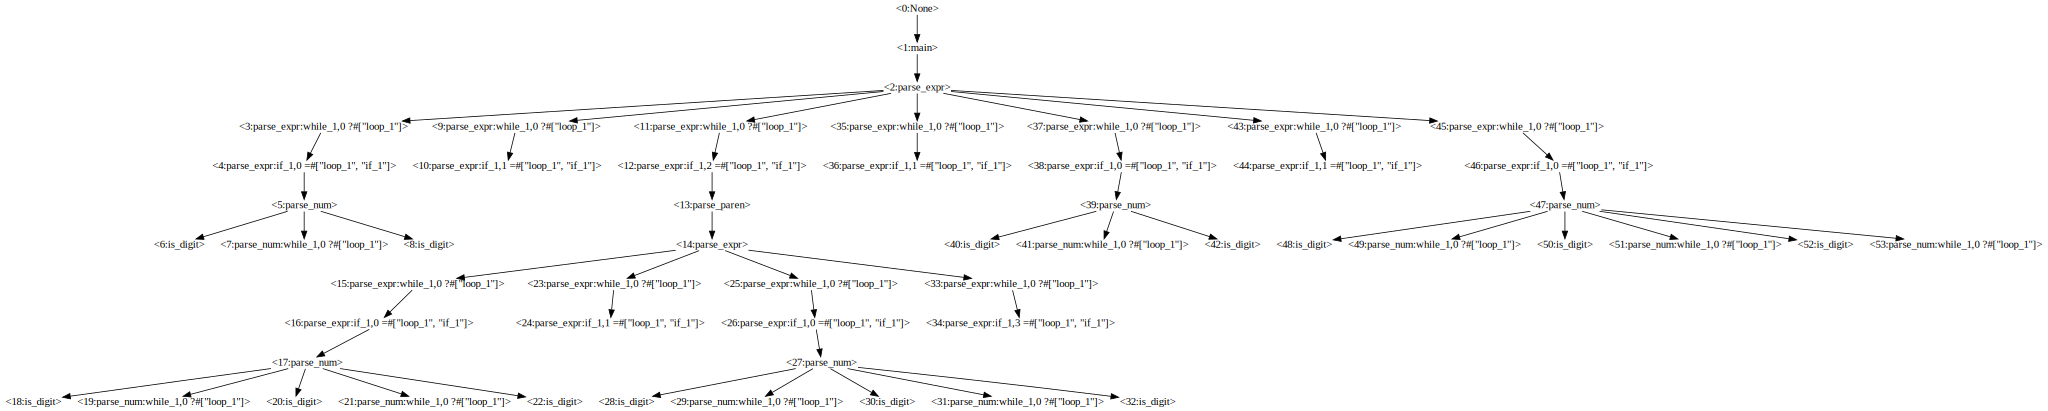

In [42]:
v

In [43]:
from IPython.display import Image

In [44]:
def zoom(v):
    return Image(v.render(format='png'))

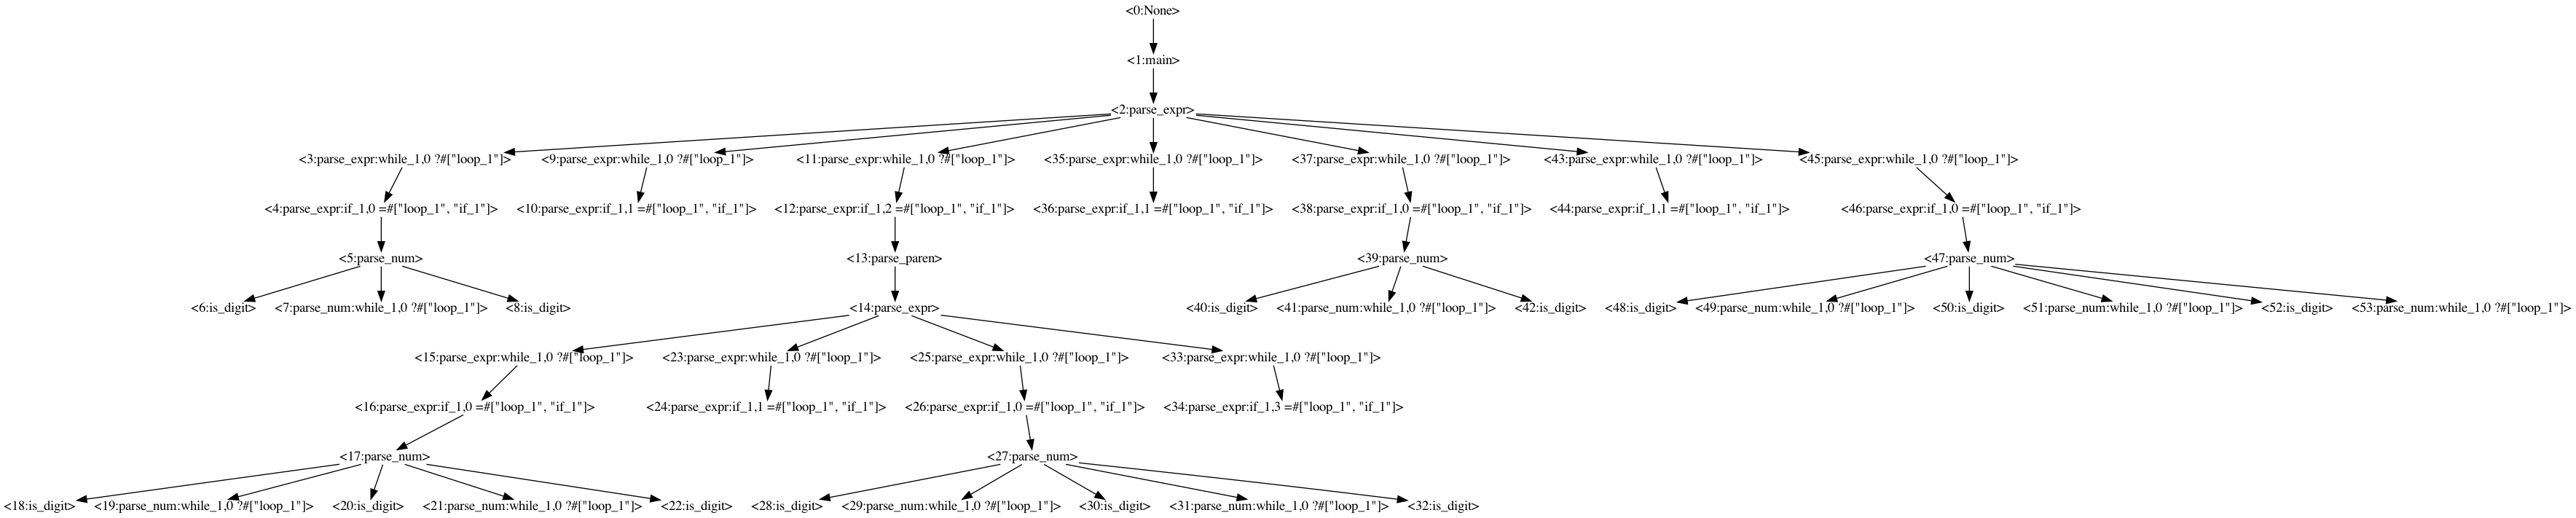

In [45]:
 zoom(v)

#### Identifying last comparisons
We need only the last comparisons made on any index. This means that we should care for only the last parse in an ambiguous parse. So, we assign the method that last touched an index to be its consumer.

However, to make concessions for real world, we also check if we are overwriting a child (`HEURISTIC`). Essentially, if the heursitic is enabled, then if the current method id (`midP`) is smaller than the `midC` already stored in the last comparison map, then it means that `midP` is a parent that called `midC` previously, and now accessing an index that `midC` touched. This happens when the parent tries to find a substring like `#` in the entirety of the original string. (Note that we have seen this only in `URLParser`). (Note that this heuristic does not restrict reparsing by another function call -- in such a case, `midC` will not smaller than `midP`). So, perhaps, we should let the child keep the ownership. However, there is one more wrinkle. If the character being contested was the last index touched by our `mid`, then it is likely that it was simply a boundary check. In that case, we should let the parent own this character.

In [46]:
LAST_COMPARISON_HEURISTIC = False

In [47]:
def last_comparisons(comparisons):
    last_cmp_only = {}
    last_idx = {}

    # get the last indexes compared in methods.
    for idx, char, mid in comparisons:
        if mid in last_idx:
            if idx > last_idx[mid]:
                last_idx[mid] = idx
        else:
            last_idx[mid] = idx

    for idx, char, mid in comparisons:
        if LAST_COMPARISON_HEURISTIC:
            if idx in last_cmp_only:
                midC = last_cmp_only[idx]
                if midC > mid:
                    # midC is a child of mid.
                    # do not clobber children unless it was the last character
                    # for that child.
                    if last_idx[mid] == idx:
                        # if it was the last index, may be the child used it
                        # as a boundary check.
                        pass
                    else:
                        # do not overwrite the current value of `last_cmp_only[idx]`
                        continue
        last_cmp_only[idx] = mid
    return last_cmp_only

Here is how one would use it.

In [48]:
calc_last_comparisons1 = last_comparisons(calc_trace[0]['comparisons'])

In [49]:
calc_last_comparisons1

{0: 6,
 1: 9,
 2: 13,
 3: 18,
 4: 20,
 5: 23,
 6: 28,
 7: 30,
 8: 13,
 9: 35,
 10: 40,
 11: 43,
 12: 48,
 13: 50,
 14: 52}

#### Attaching characters to the tree
Add the comparison indexes to the method tree that we constructed

In [50]:
def attach_comparisons(method_tree, comparisons):
    for idx in comparisons:
        mid = comparisons[idx]
        method_tree[mid]['indexes'].append(idx)

Here is how one would use it. Note which method call each input index is associated. For example, the first index is associated with method call id: 6, which corresponds to `is_digit`.

In [51]:
attach_comparisons(calc_method_tree1, calc_last_comparisons1)

In [52]:
calc_method_tree1

{0: {'id': 0,
  'name': None,
  'children': [{'id': 1,
    'name': 'main',
    'indexes': [],
    'children': [{'id': 2,
      'name': 'parse_expr',
      'indexes': [],
      'children': [{'id': 3,
        'name': 'parse_expr:while_1,0 ?#["loop_1"]',
        'indexes': [],
        'children': [{'id': 4,
          'name': 'parse_expr:if_1,0 =#["loop_1", "if_1"]',
          'indexes': [],
          'children': [{'id': 5,
            'name': 'parse_num',
            'indexes': [],
            'children': [{'id': 6,
              'name': 'is_digit',
              'indexes': [0],
              'children': []},
             {'id': 7,
              'name': 'parse_num:while_1,0 ?#["loop_1"]',
              'indexes': [],
              'children': []},
             {'id': 8,
              'name': 'is_digit',
              'indexes': [],
              'children': []}]}]}]},
       {'id': 9,
        'name': 'parse_expr:while_1,0 ?#["loop_1"]',
        'indexes': [1],
        'children': [{'id': 

In [53]:
class DisplayTree2(DisplayTree):
    def __init__(self, derivation_tree, istr):
        super().__init__(derivation_tree)
        self.istr = istr

    def extract_node(self, node, id):
        symbol = str(node['id'])
        children = node['children']
        annotation = str(node['name'])
        indexes = repr(tuple([self.istr[i] for i in node['indexes']]))
        return "<%s %s>" % (annotation, indexes), children, ''

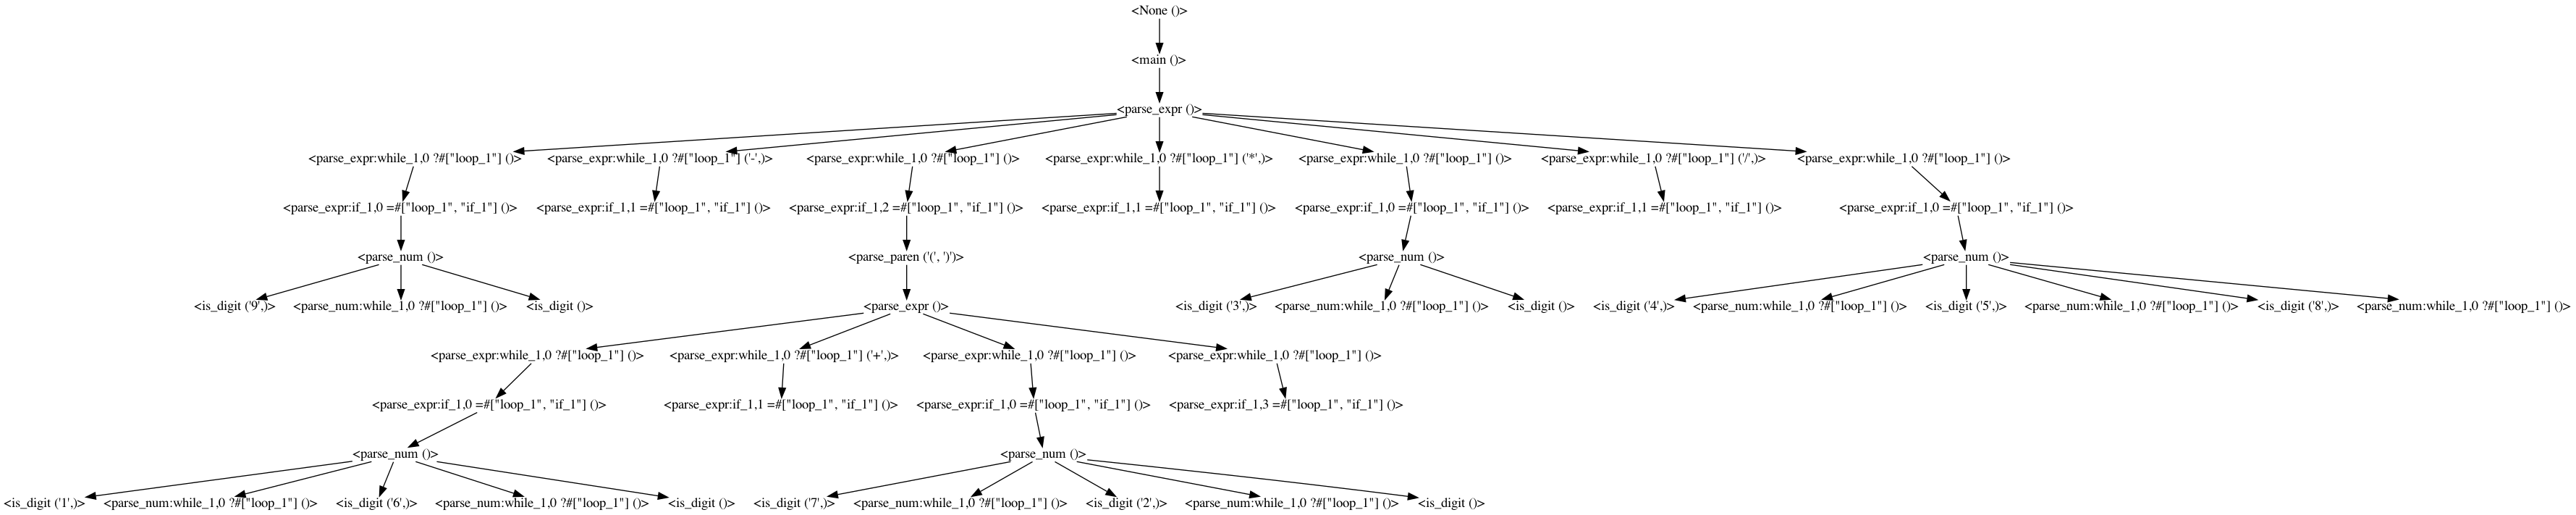

In [54]:
zoom(v:=DisplayTree2(calc_method_tree1[0], calc_trace[0]['inputstr']).display())

We define `to_node()` a convenience function that, given a list of _contiguous_ indexes and original string, translates it to a leaf node of a tree (that corresponds to the derivation tree syntax in the Fuzzingbook) with a string, empty children, and starting node and ending node.

Convert a list of indexes to a corresponding terminal tree node

In [55]:
def to_node(idxes, my_str):
    assert len(idxes) == idxes[-1] - idxes[0] + 1
    assert min(idxes) == idxes[0]
    assert max(idxes) == idxes[-1]
    return my_str[idxes[0]:idxes[-1] + 1], [], idxes[0], idxes[-1]

Here is how one would use it.

In [56]:
for k in calc_method_tree1.keys():
    idxs = calc_method_tree1[k]['indexes']
    if idxs:
        print(k, idxs)

9 [1]
35 [9]
43 [11]
6 [0]
13 [2, 8]
23 [5]
18 [3]
20 [4]
28 [6]
30 [7]
40 [10]
48 [12]
50 [13]
52 [14]


In [57]:
to_node(calc_method_tree1[9]['indexes'], calc_trace[0]['inputstr'])

('-', [], 1, 1)

In [58]:
from operator import itemgetter
import itertools as it

We now need to identify the terminal (leaf) nodes. For that, we want to group contiguous letters in a node together, and call it a leaf node. So, convert our list of indexes to lists of contiguous indexes first, then convert them to terminal tree nodes. Then, return a set of one level child nodes with contiguous chars from indexes.

In [59]:
def indexes_to_children(indexes, my_str):
    lst = [
        list(map(itemgetter(1), g))
        for k, g in it.groupby(enumerate(indexes), lambda x: x[0] - x[1])
    ]

    return [to_node(n, my_str) for n in lst]

In [60]:
indexes_to_children(calc_method_tree1[9]['indexes'], calc_trace[0]['inputstr'])

[('-', [], 1, 1)]

Finally, we need to remove the overlap from the trees we have so far. The idea is that, given a node, each child node of that node should be uniquely responsible for a specified range of characters, with no overlap allowed between the children. The starting of the first child to ending of the last child will be the range of the node.

#### Removing Overlap
If overlap is found, the tie is biased to the later child. That is, the later child gets to keep the range, and the former child is recursively traversed to remove overlaps from its children. If a child is completely included in the overlap, the child is excised. A few convenience functions first:

In [61]:
def does_item_overlap(r, r_):
    (s, e), (s_, e_) = r, r_
    return ((s_ >= s and s_ <= e) or 
            (e_ >= s and e_ <= e) or 
            (s_ <= s and e_ >= e))

In [62]:
def is_second_item_included(r, r_):
    (s, e), (s_, e_) = r, r_
    return (s_ >= s and e_ <= e)

In [63]:
def has_overlap(ranges, r_):
    return {r for r in ranges if does_item_overlap(r, r_)}

In [64]:
def is_included(ranges, r_):
    return {r for r in ranges if is_second_item_included(r, r_)}

In [65]:
def remove_overlap_from(original_node, orange):
    node, children, start, end = original_node
    new_children = []
    if not children:
        return None
    start = -1
    end = -1
    for child in children:
        if does_item_overlap(child[2:4], orange):
            new_child = remove_overlap_from(child, orange)
            if new_child: # and new_child[1]:
                if start == -1: start = new_child[2]
                new_children.append(new_child)
                end = new_child[3]
        else:
            new_children.append(child)
            if start == -1: start = child[2]
            end = child[3]
    if not new_children:
        return None
    assert start != -1
    assert end != -1
    return (node, new_children, start, end)

Verify that there is no overlap.

In [66]:
def no_overlap(arr):
    my_ranges = {}
    for a in arr:
        _, _, s, e = a
        r = (s, e)
        included = is_included(my_ranges, r)
        if included:
            continue  # we will fill up the blanks later.
        else:
            overlaps = has_overlap(my_ranges, r) 
            if overlaps:
                # unlike include which can happen only once in a set of
                # non-overlapping ranges, overlaps can happen on multiple parts.
                # The rule is, the later child gets the say. So, we recursively
                # remove any ranges that overlap with the current one from the
                # overlapped range.
                assert len(overlaps) == 1
                oitem = list(overlaps)[0]
                v = remove_overlap_from(my_ranges[oitem], r)
                del my_ranges[oitem]
                if v:
                    my_ranges[v[2:4]] = v
                my_ranges[r] = a
            else:
                my_ranges[r] = a
    res = my_ranges.values()
    # assert no overlap, and order by starting index
    s = sorted(res, key=lambda x: x[2])
    return s

#### Generate derivation tree

Convert a mapped tree to the _fuzzingbook_ style derivation tree.

In [67]:
def to_tree(node, my_str):
    method_name = ("<%s>" % node['name']) if node['name'] is not None else '<START>'
    indexes = node['indexes']
    node_children = [to_tree(c, my_str) for c in node.get('children', [])]
    idx_children = indexes_to_children(indexes, my_str)
    children = no_overlap([c for c in node_children if c is not None] + idx_children)
    if not children:
        return None
    start_idx = children[0][2]
    end_idx = children[-1][3]
    si = start_idx
    my_children = []
    # FILL IN chars that we did not compare. This is likely due to an i + n
    # instruction.
    for c in children:
        if c[2] != si:
            sbs = my_str[si: c[2]]
            my_children.append((sbs, [], si, c[2] - 1))
        my_children.append(c)
        si = c[3] + 1

    m = (method_name, my_children, start_idx, end_idx)
    return m

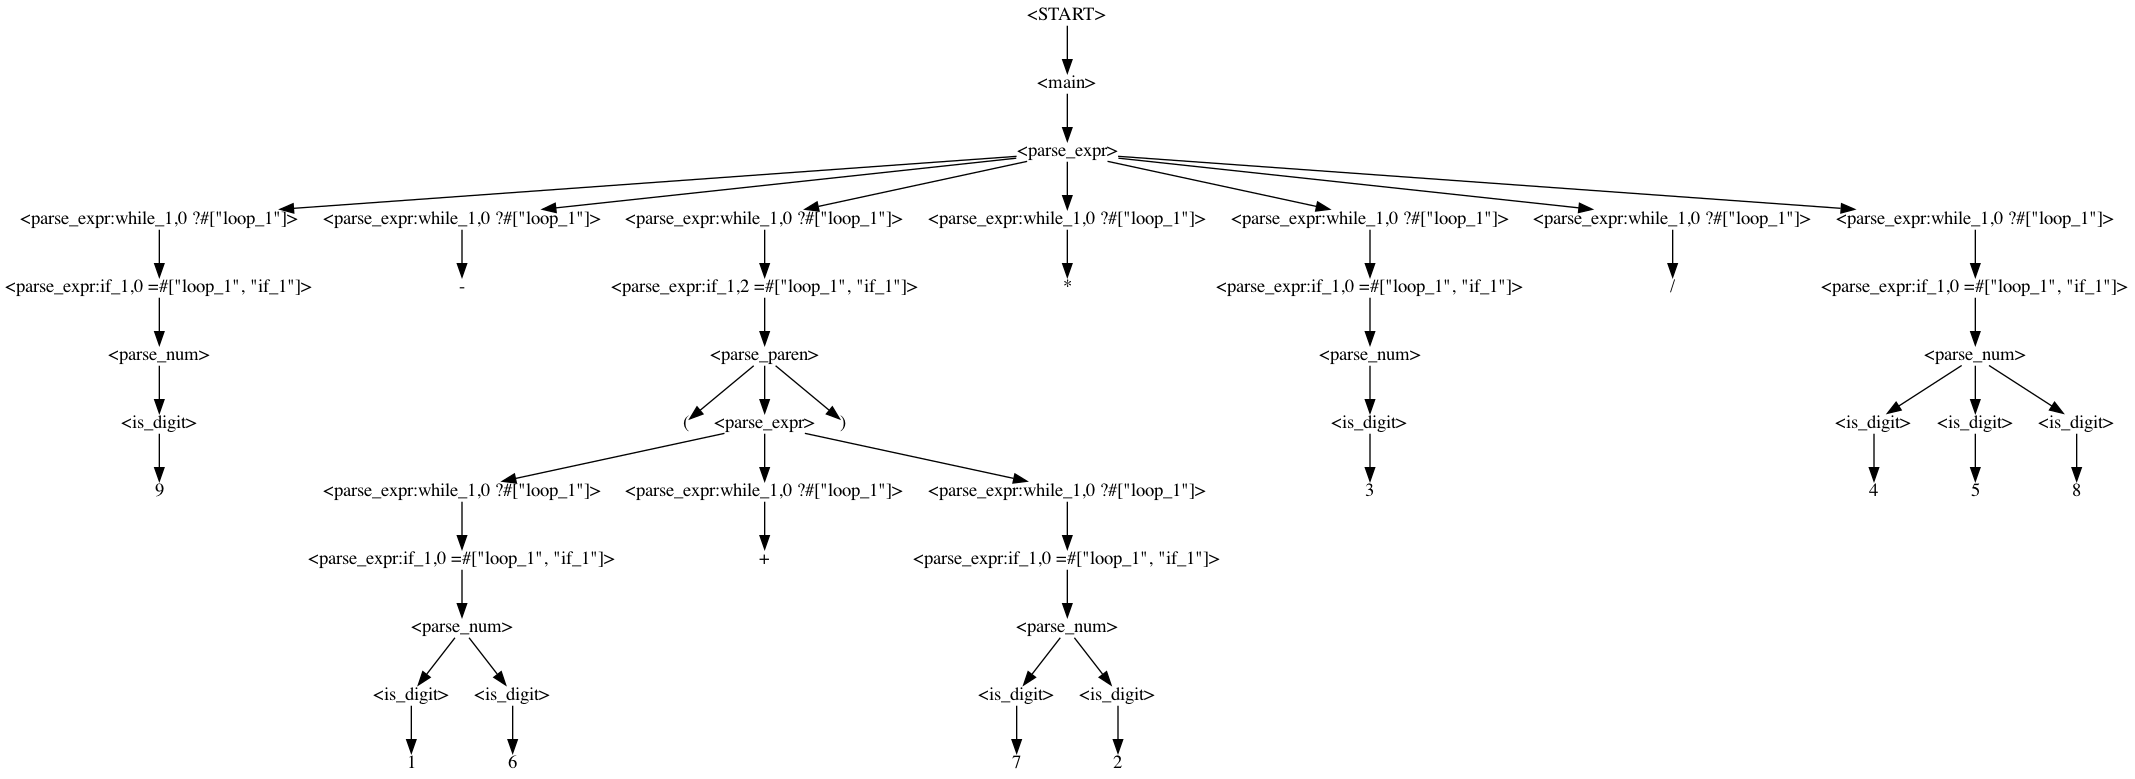

In [68]:
zoom(v:=utils.display_tree(to_tree(calc_method_tree1[0], calc_trace[0]['inputstr'])))

### The Complete Miner

We now put everything together. The `miner()` takes the traces, produces trees out of them, and verifies that the trees actually correspond to the input.

In [69]:
def tree_to_str(tree): # Non recursive
    expanded = []
    to_expand = [tree]
    while to_expand:
        (key, children, *rest), *to_expand = to_expand
        if utils.is_nt(key):
            to_expand = children + to_expand
        else:
            assert not children
            expanded.append(key)
    return ''.join(expanded)

In [70]:
def miner(call_traces):
    my_trees = []
    for call_trace in call_traces:
        with open('last_trace.json', 'w+') as f:
            json.dump([call_trace], fp=f)
        method_map = call_trace['method_map']

        first, method_tree = reconstruct_method_tree(method_map)
        comparisons = call_trace['comparisons']
        attach_comparisons(method_tree, last_comparisons(comparisons))

        my_str = call_trace['inputstr']

        tree = to_tree(method_tree[first], my_str)
        my_tree = {'tree': tree, 'original': call_trace['original'], 'arg': call_trace['arg']}
        assert tree_to_str(tree) == my_str
        my_trees.append(my_tree)
    return my_trees

Using the `miner()`

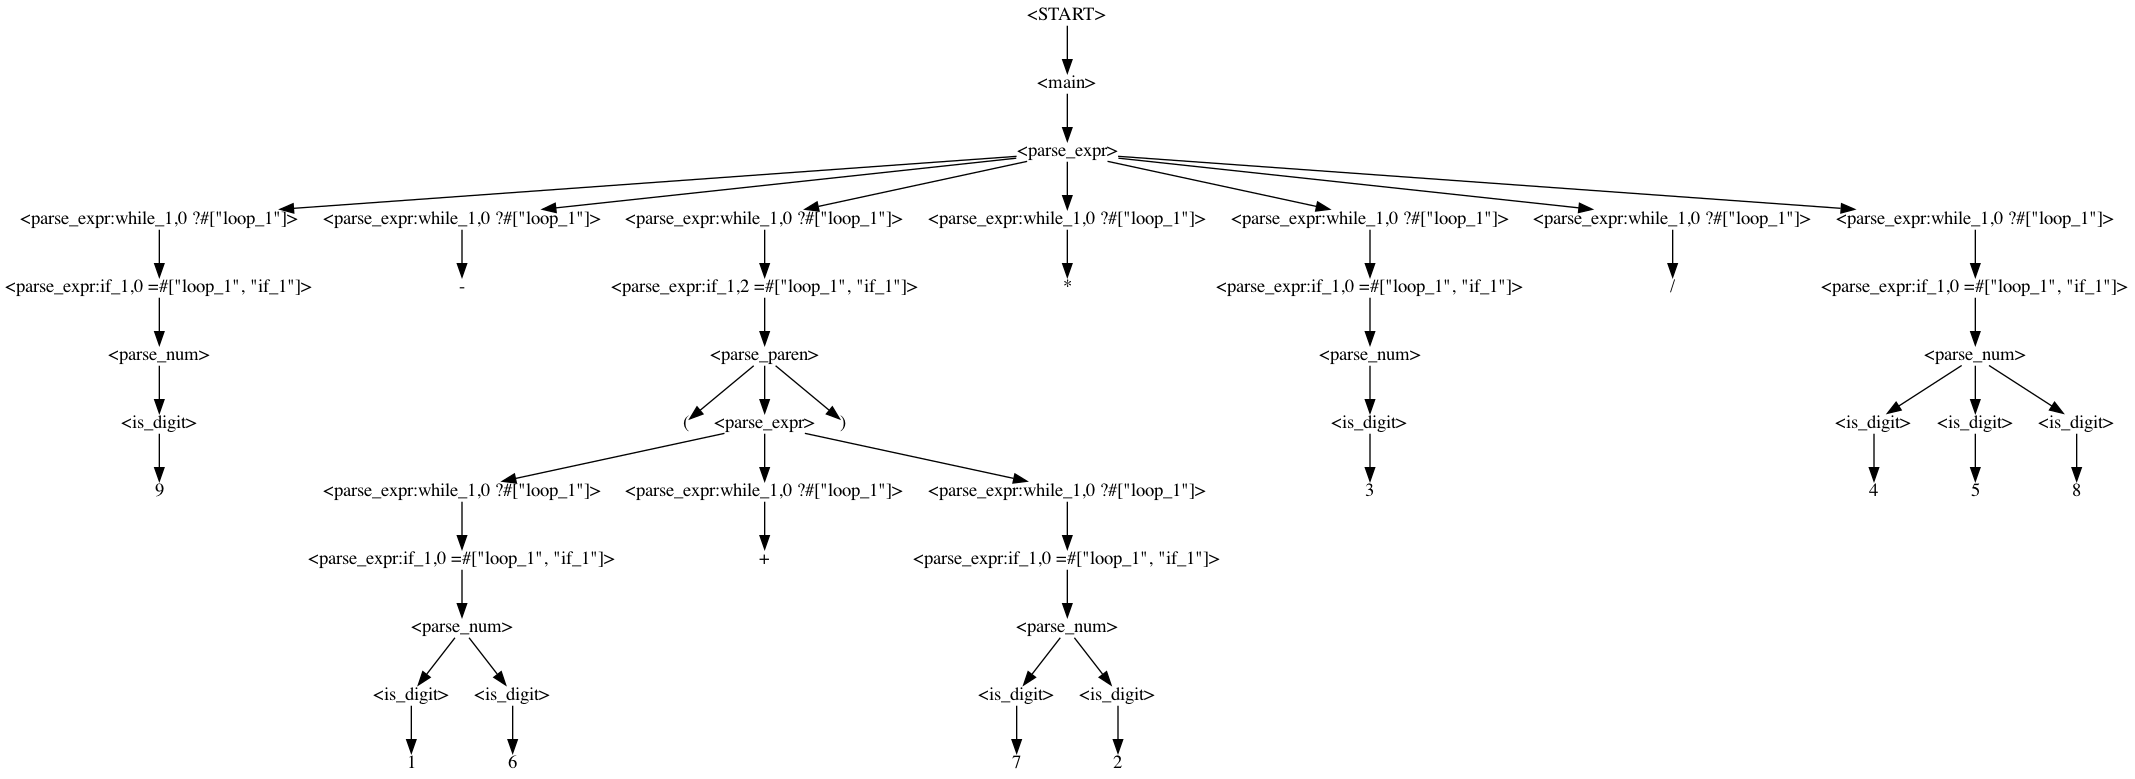

In [71]:
mined_calc_trees = miner(calc_trace)
calc_tree = mined_calc_trees[0]
zoom(v:=utils.display_tree(calc_tree['tree']))

## Generalize Nodes

Constants to limit our exploration. The `MAX_PROC_SAMPLES` is used to specify how many samples to match for getting a swap patter.

In [72]:
MAX_PROC_SAMPLES = 100

Caching and book keeping variables.

In [73]:
EXEC_MAP = {}
NODE_REGISTER = {}

In [74]:
def reset_generalizer():
    global EXEC_MAP
    global NODE_REGISTER
    EXEC_MAP.clear()
    NODE_REGISTER.clear()

Given that we are evaluating Python functions, we need a wrapper to make them executable.

A small library function to convert from tuple to lists so that we can modify a tree.

In [75]:
def to_modifiable(derivation_tree):
    node, children, *rest = derivation_tree
    return [node, [to_modifiable(c) for c in children], *rest]

### Generalize Methods

The idea here is that, sometimes one finds that our central assumption -- that a fragment consumed by a function can be replaced by another fragment consumed by the same function elsewhere -- doesn't hold. This can be seen in functions that take an additional argument to specify what it should match. In such cases, we want to try and find out how to distinguish between these function invocations. 

`node_include()` is a library function that checks whether the node `j` is within the boundary of `i`.

In [76]:
def node_include(i, j):
    name_i, children_i, s_i, e_i = i
    name_j, children_j, s_j, e_j = j
    return is_second_item_included((s_i, e_i), (s_j, e_j))

The `get_ref()` takes a `node` datastructure and searches for `node_name`. It returns the first instance found. This allows us to easily swap nodes.

In [77]:
def get_ref(node, node_name):
    name, children, *rest = node
    if name == node_name:
        return node
    for child in children:
        res = get_ref(child, node_name)
        if res is not None: return res
    return None

 The `replace_nodes()` function try to replace the contents of the first node with the _contents_ of the second (That is, the tree that has these nodes will automatically be modified), collect the produced string from the tree, and reset any changes. The arguments are tuples with the following format: (node, file_name, tree)

In [78]:
# replace the given node in a2 by the node in a1
def replace_nodes(a2, a1):
    node2, _, t2 = a2
    node1, _, t1 = a1
    str2_old = tree_to_str(t2)

    # first change the name of the node, then copy the tree.
    tmpl_name = '___cmimid___'
    old_name = node2[0]
    node2[0] = tmpl_name
    t2_new = utils.deep_copy(t2)
    node2[0] = old_name

    # now find the reference to tmpl_name in t2_new
    node2 = get_ref(t2_new, tmpl_name)
    node2.clear()
    for n in node1:
        node2.append(n)
    str2_new = tree_to_str(t2_new)
    assert str2_old != str2_new
    return t2_new

Can a given node be replaced with another? The idea is, given two nodes (possibly from two trees), can the first node be replaced by the second, and still result in a valid string?

In [79]:
def is_a_replaceable_with_b(a1, a2, module):
    n1, f1, t1 = a1
    n2, f2, t2 = a2
    if tree_to_str(n1) == tree_to_str(n2): return True
    t_x = replace_nodes(a1, (('XXXX', []), None, t2))
    x = tree_to_str(t_x)
    updated_tree = replace_nodes(a1, a2)
    updated_string = tree_to_str(updated_tree)
    o = tree_to_str(t1)
    v = check(o, x, n1[0], updated_tree, module, tree_to_str(a1[0]), tree_to_str(a2[0]))
    return v

In [80]:
def is_compatible(a1, a2, module):
    t1 = is_a_replaceable_with_b(a1, a2, module)
    if not t1: return False
    t2 = is_a_replaceable_with_b(a2, a1, module)
    return t2

There are fundamentally, two kinds of nodes. The first kind of node is a method node, that correspond to a method call. The second is a node that corresponds to a pseudo-method -- that is, a node that represents a loop or a conditional. Below are the predicates that identify such methods, parses, and reconstructs such nodes.

In [81]:
def is_node_method(node):
    node_name = node[0]
    if (node_name[0], node_name[-1]) != ('<', '>'): return False
    return not is_node_pseudo(node)

In [82]:
def is_node_pseudo(node):
    node_name = node[0]
    if (node_name[0], node_name[-1]) != ('<', '>'): return False
    if ':if_' in node_name: return True
    if ':while_' in node_name: return True
    return False

In [83]:
def parse_pseudo_name(node_name):
    assert (node_name[0], node_name[-1]) == ('<','>')
    return decode_name(node_name[1:-1])

In [84]:
def parse_method_name(mname):
    assert (mname[0], mname[-1]) == ('<', '>')
    name = mname[1:-1]
    if '.' in name:
        nname, my_id = name.split('.')
        return nname, my_id
    else:
        return name, '0'

In [85]:
def decode_name(node_name_stack):
    node_name, mstack = node_name_stack.split('#')
    method_stack = json.loads(mstack)
    method_ctrl_alt_name, can_empty = node_name.split(' ')
    method, ctrl_cid_altid = method_ctrl_alt_name.split(':')
    ctrl, cid_altid = ctrl_cid_altid.split('_')
    assert ctrl in {'while', 'if'}
    cid, altid = cid_altid.split(',')

    if 'while' == ctrl:
        assert altid == '0'
    return method, ctrl, int(cid), altid, can_empty, method_stack

In [86]:
def unparse_pseudo_name(method, ctrl, ctrl_id, alt_num, can_empty, cstack):
    return "<%s>" % encode_name(method, ctrl, ctrl_id, alt_num, can_empty, cstack)

def unparse_method_name(mname, my_id):
    return '<%s.%s>' % (mname, my_id)

def encode_name(method, ctrl, ctrl_id, alt_num, can_empty, stack):
    assert ctrl in {'while', 'if'}
    return '%s:%s_%s,%s %s#%s' % (method, ctrl, ctrl_id, alt_num, can_empty, json.dumps(stack))

The `check()` function invokes the given subject call with the previously defined `check.py` wrapper, logs and returns the result of the call.

**TODO**: What we really want to do, is to generate a new updated tree first after doing the tree surgery. Then, convert this tree to a parenthesized tree by simply doing `tree_to_string` with additional `{}` (or other open/close symbols that does not conflict with the input) attached when joining the nodes. That is,

In [87]:
def tree_to_pstr(tree, op_='', _cl=''):
    expanded = []
    to_expand = [tree]
    while to_expand:
        (key, children, *_), *to_expand = to_expand
        if utils.is_nt(key):
            expanded.append(op_)
            to_expand = children + [(_cl, [])] + to_expand
        else:
            assert not children
            expanded.append(key)
    return ''.join(expanded)

With this, when using `tree_to_string(my_tree, '{', '}')`, We will get a string that represents how the original string was parsed. For example `1+2+3` may be represented as `{{1+2}+3}`.

Next, we need to run the non-parenthesized string resulting from the tree surgery through the program, and collect the resulting tree. Again, convert this tree to the parentesized version, and compare equality.

With this, we can ensure that our tree nodes are correctly compatible, and secondly, we can ignore the return code.

In [88]:
def check(o, x, e, ut, module, sa1, sa2):
    s = tree_to_str(ut)
    if s in EXEC_MAP: return EXEC_MAP[s]
    updated_ps = tree_to_pstr(ut, op_='{', _cl='}')
    tn = "build/_test.csv"
    with open(tn, 'w+') as f: print(s, file=f)

    trace_out = utils.do([sys.executable,"build/%(m)s" % {'m': module}, tn] ).stdout
    val = None
    v = False
    parsed_ps = None
    try:
        val = json.loads(trace_out)
        parsed_tree = miner(val)[0]['tree']
        parsed_ps = tree_to_pstr(parsed_tree, op_='{', _cl='}')
        v = (parsed_ps == updated_ps)
    except:
        parsed_ps = 'ERROR'
        v = False
  
    with open('%s.log' % module, 'a+') as f:
        print('------------------', file=f)
        print(' '.join([sys.executable, "build/%s" % module, s]), file=f)
        print('Checking:',e, file=f)
        print('original:', repr(o), file=f)
        print('tmpl:', repr(x), file=f)
        print('updated:', repr(s), file=f)
        print('XXXX:', repr(sa1), file=f)
        print('REPL:', repr(sa2), file=f)
        print('ops:', repr(updated_ps), file=f)
        print('pps:', repr(parsed_ps), file=f)
        print(":=", v, file=f)
    #     print(' '.join([module, repr(s)]), file=f)
    #     print("\n", file=f)
    # v = (result.returncode == 0)
    EXEC_MAP[s] = v
    return v

We now want to collect all nodes of a particular kind together. `register_node()` correctly saves specific kinds of nodes separately as copies.

In [89]:
def register_node(node, tree, executable, input_file):
    # we want to save a copy of the tree so we can modify it later. 
    node_name = node[0]
    template_name = '__CMIMID__NODE__'
    node[0] = template_name
    new_tree = utils.deep_copy(tree)
    node[0] = node_name
    new_node = get_ref(new_tree, template_name)
    new_node[0] = node_name
    if node_name not in NODE_REGISTER:
        NODE_REGISTER[node_name] = []
    new_elt = (new_node, new_tree, executable, input_file,
            {'inputstr': tree_to_str(new_tree), 'node':node, 'tree':tree})
    NODE_REGISTER[node_name].append(new_elt)
    return new_elt

`collect_nodes()` recursively calls `register_node()` on the tree so that all nodes are registered. The wrinkle here is that in some case such as parser combinators and peg parsers, there may be long chains of single child repetitions. i.e: `parse -> curry -> parse -> curry -> ...` etc. For them, if we have seen the first `parse` and `curry`, we do not gain anything by analyzing the remainign in the *same chain*. So, we mark such chains.

In [90]:
def collect_nodes_single(node, tree, executable, inputfile, seen):
    node_name, children, si, ei = node
    elt = None
    if is_node_method(node):
        elt = register_node(node, tree, executable, inputfile)
        if node_name in seen:
            elt[4]['seen'] = seen[node_name]
        else:
            seen[node_name] = elt
    if len(children) == 1:
        collect_nodes_single(children[0], tree, executable, inputfile, seen)
    else:
        # no longer the single inheritance line.
        for child in children:
            collect_nodes(child, tree, executable, inputfile)

In [91]:
def collect_nodes(node, tree, executable, inputfile):
    node_name, children, si, ei = node
    elt = None
    if is_node_method(node):
        elt = register_node(node, tree, executable, inputfile)
    if len(children) == 1:
        collect_nodes_single(children[0], tree, executable, inputfile, {node_name: elt})
    else:
        for child in children:
            collect_nodes(child, tree, executable, inputfile)

When looking to see which methods are swappable, the idea is to choose a small sample set for a given node name, and check the current node against that sample set (swap both ways, and check the validity). The different validity patterns we get are marked as different kinds of nodes.

Here, we identify the buckets based on one to one compatibility. Unfortunately, there is a problem here. Essentially, we assume that if `a` is compatible with `b`, and `b` is compatible with `c`, then `a` is compatible with `c`. However, this may not be true in all cases. See the limitations for instances when this assumption is invalidated. At this point, we have several options. The first is to do an $n \times n$ comparison of all items in the bucket, in which case, we will have the true compatibility but with high computational cost. The next alternative is to choose a node in one bucket, and do the bucketing procedure again with the items in the particular bucket. This produces one more bit of information, and one can continue this prodcedure for larger and larger number of bits. One may also choose a statistical sample of $k$ items in the bucket, and go for a comparison only between $n \times k$ items.

At this point, we choose the fastest option, which gets us a reasonable accuracy. We use a single level classification.

In [92]:
def identify_buckets(node_name):
    all_elts = NODE_REGISTER[node_name]
    # remove the duplicate nodes
    elts = [e for e in all_elts if 'seen' not in e[4]]
    seen_elts = [e for e in all_elts if 'seen' in e[4]]
    first, *rest = elts
    first[4]['pattern'] = 0
    buckets = [first]
    for enode in rest:
        node0, tree0, executable0, inputfile0, _info0 = enode
        a0 = node0, inputfile0, tree0
        compatible = None
        for bi, bnode in enumerate(buckets):
            node1, tree1, executable1, inputfile1, _info1 = bnode
            a1 = node1, inputfile1, tree1
            result = is_compatible(a0, a1, executable0)
            if result:
                compatible = bi
                enode[4]['pattern'] = bi
                break
        if compatible is None:
            enode[4]['pattern'] = len(buckets)
            buckets.append(enode)
            
    for e in seen_elts:
        e_seen = e[4]['seen']
        e_seen_pattern = e_seen[4]['pattern']
        e[4]['pattern'] = e_seen_pattern
    return {i:i for i,b in enumerate(buckets)}

Once we identify that a node belongs to a particular pattern identifier, we update all the pseudo-methods belonging to that node. These can be found by simply traversiing the tree until the next method is found.

In [93]:
def update_method_stack(node, old_name, new_name):
    nname, children, *rest = node
    if not (':if_' in nname or ':while_' in nname):
        return
    method, ctrl, cname, num, can_empty, cstack = parse_pseudo_name(nname)
    assert method == old_name, "%s != %s" % (method, old_name)
    name = unparse_pseudo_name(new_name, ctrl, cname, num, can_empty, cstack)
    #assert '?' not in name
    node[0] = name
    for c in node[1]:
        update_method_stack(c, old_name, new_name)

In [94]:
def update_method_name(k_m, my_id):
    # fixup k_m with what is in my_id
    original = k_m[0]
    method, old_id = parse_method_name(original)
    name = unparse_method_name(method, my_id)
    k_m[0] = name

    for c in k_m[1]:
        update_method_stack(c, original[1:-1], name[1:-1])

    return name, k_m

In [95]:
def update_original_method_names(node_name):
    registered_xnodes = NODE_REGISTER[node_name]
    for xnode in registered_xnodes:
        # name it according to its pattern
        nodeX, treeX, executableX, inputfileX, infoX = xnode
        pattern = infoX['pattern']
        update_method_name(infoX['node'], pattern)

The idea is to first collect and register all nodes by their names.
Next, we sample N of these, and use the pattern of matches
(**TODO**: Do we simply use the pattern of compatibility or the pattern
of left to right replaceability -- that is, a is replaceable with b
but b is not replaceable with a is 10 while full compatibility would
be 11 -> 1)

In [96]:
def generalize_method_trees(jtrees, log=False):
    my_trees = []
    for i,j in enumerate(jtrees):
        tree = to_modifiable(j['tree']) # The tree ds.
        executable = j['original']
        inputfile = j['arg']
        # we skip START
        node_name, children, *rest = tree
        assert node_name == '<START>'
        for child in children:
            collect_nodes(tree, tree, executable, inputfile)
        my_trees.append({'tree':tree, 'original': executable, 'arg': inputfile})

    for k in NODE_REGISTER:
        identify_buckets(k)

    # finally, update the original names.
    for k in NODE_REGISTER:
        if k == '<START>': continue
        update_original_method_names(k)
    return my_trees

Here is how we use it.

In [97]:
reset_generalizer()
mg_calc_trees = generalize_method_trees(mined_calc_trees)

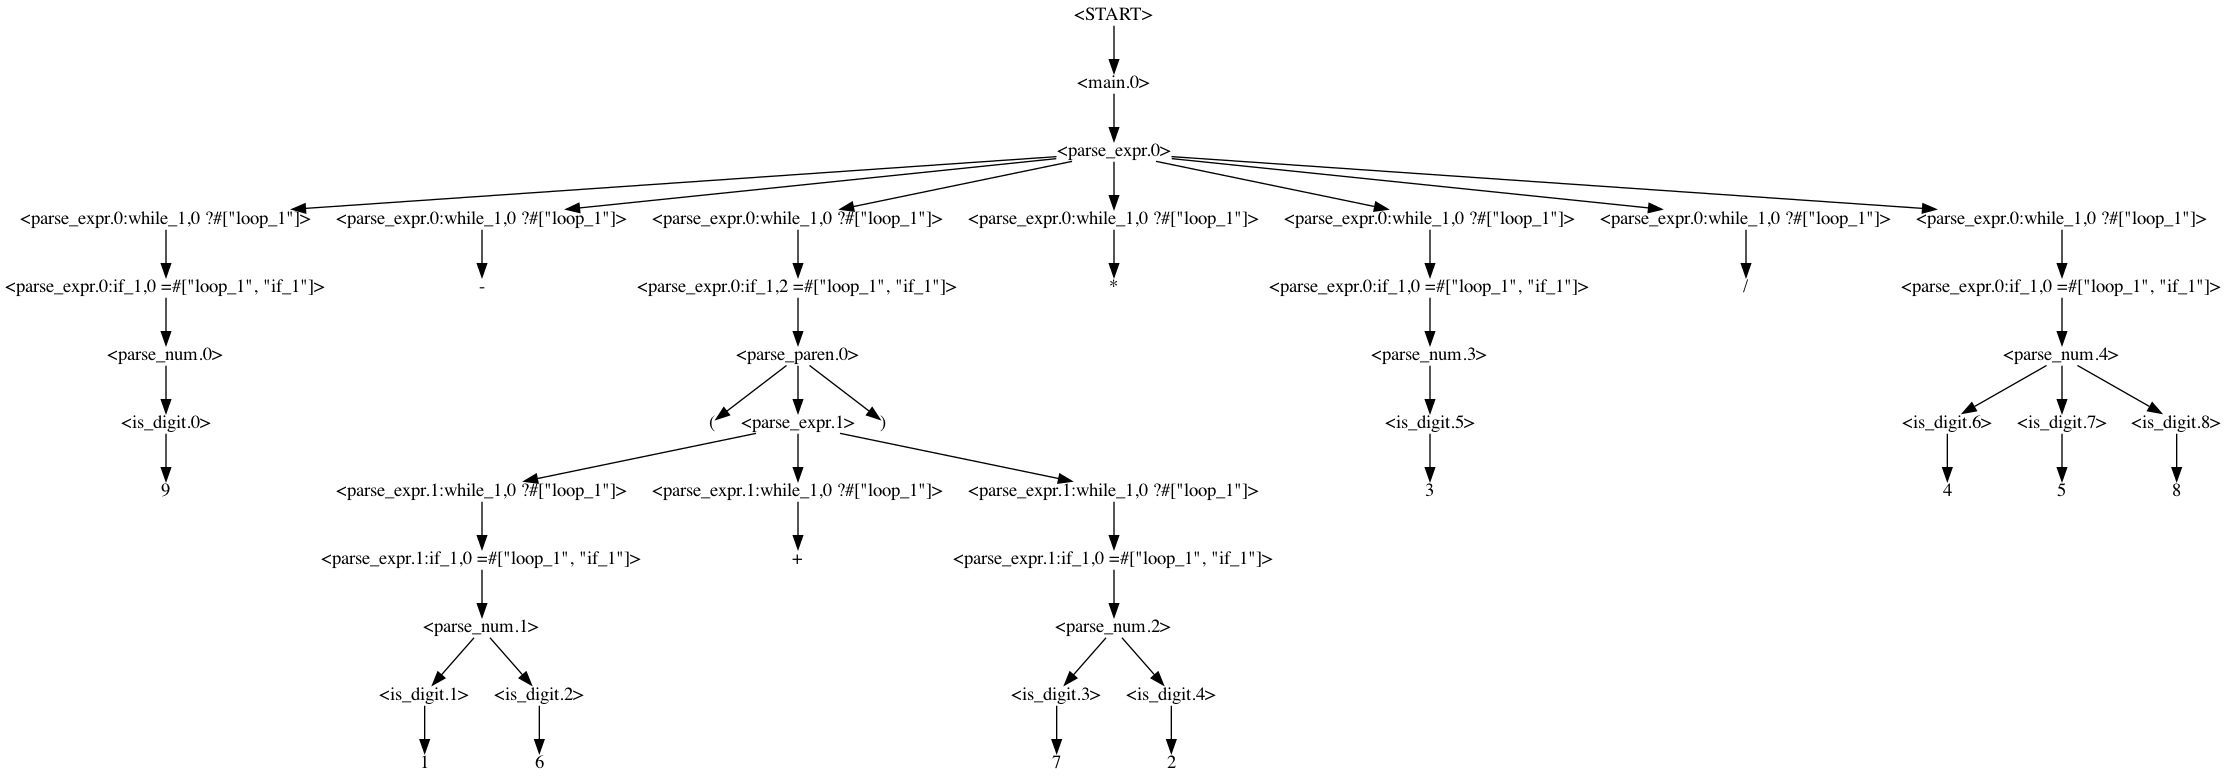

In [98]:
zoom(v:=utils.display_tree(mg_calc_trees[0]['tree']))

### Generalize Loops

We now define how to update a pseudoname to a new id (when we detect a new pattern).

In [99]:
def update_pseudo_name(k_m, my_id):
    # fixup k_m with what is in my_id
    original = k_m[0]
    method, ctrl, cid, altid, can_empty, method_stack = parse_pseudo_name(original)
    if ctrl == 'if':
        name = unparse_pseudo_name(method, ctrl, cid, "%s.%d" % (altid, my_id), can_empty, method_stack)
    elif ctrl == 'while':
        assert altid == '0'
        name = unparse_pseudo_name(method, ctrl, cid, my_id, can_empty, method_stack)
    else:
        assert False
    k_m[0] = name
    return name, k_m

def update_original_pseudo_names(node_name):
    registered_xnodes = NODE_REGISTER[node_name]
    for xnode in registered_xnodes:
        # name it according to its pattern
        nodeX, treeX, executableX, inputfileX, infoX = xnode
        pattern = infoX['pattern']
        update_pseudo_name(infoX['node'], pattern)

For generalizing pseudonodes, we need to collect them just like we did for methods.

In [100]:
def collect_pseudo_nodes(node, tree, executable, inputfile):
    node_name, children, si, ei = node
    if is_node_pseudo(node):
        register_node(node, tree, executable, inputfile)

    for child in children:
        collect_pseudo_nodes(child, tree, executable, inputfile)

For loops, we have a special processing that checks whether it can be deleted. If so, we would place `*` after their name. Else it is `+`

In [101]:
def can_the_loop_be_deleted(pattern, k, executable):
    xnodes = [xnode for xnode in NODE_REGISTER[k] if xnode[-1]['pattern'] == pattern]
    can_be_deleted = True
    for xnode in xnodes:
        node0, tree0, executable0, inputfile0, _info = xnode
        a = is_a_replaceable_with_b((node0, '', tree0), (['', [], 0, 0], '', tree0), executable)
        if not a:
            can_be_deleted = False
            break
    for xnode in xnodes:
        node0, tree0, executable0, inputfile0, info = xnode
        method1, ctrl1, cname1, num1, can_empty, cstack1 = parse_pseudo_name(node0[0])
        name = unparse_pseudo_name(method1, ctrl1, cname1, num1, Epsilon if can_be_deleted else NoEpsilon, cstack1)
        info['node'][0] = name

The main `generalize_loop_trees()` generalizes loops.

In [102]:
def generalize_loop_trees(jtrees, log=False):
    my_trees = []
    for j in jtrees:
        tree = to_modifiable(j['tree']) # The tree ds.
        executable = j['original']
        inputfile = j['arg']
        # we skip START
        node_name, children, *rest = tree
        assert node_name == '<START>'
        for child in children:
            collect_pseudo_nodes(tree, tree, executable, inputfile)
        my_trees.append({'tree':tree, 'original': executable, 'arg': inputfile})

    for k in NODE_REGISTER:
        patterns = identify_buckets(k)
        for p in patterns:
            can_the_loop_be_deleted(patterns[p], k, executable)

    # finally, update the original names.
    for k in NODE_REGISTER:
        if k == '<START>': continue
        update_original_pseudo_names(k)
    return my_trees

It is used as follows:

In [103]:
reset_generalizer()
lg_calc_trees = generalize_loop_trees(mg_calc_trees)

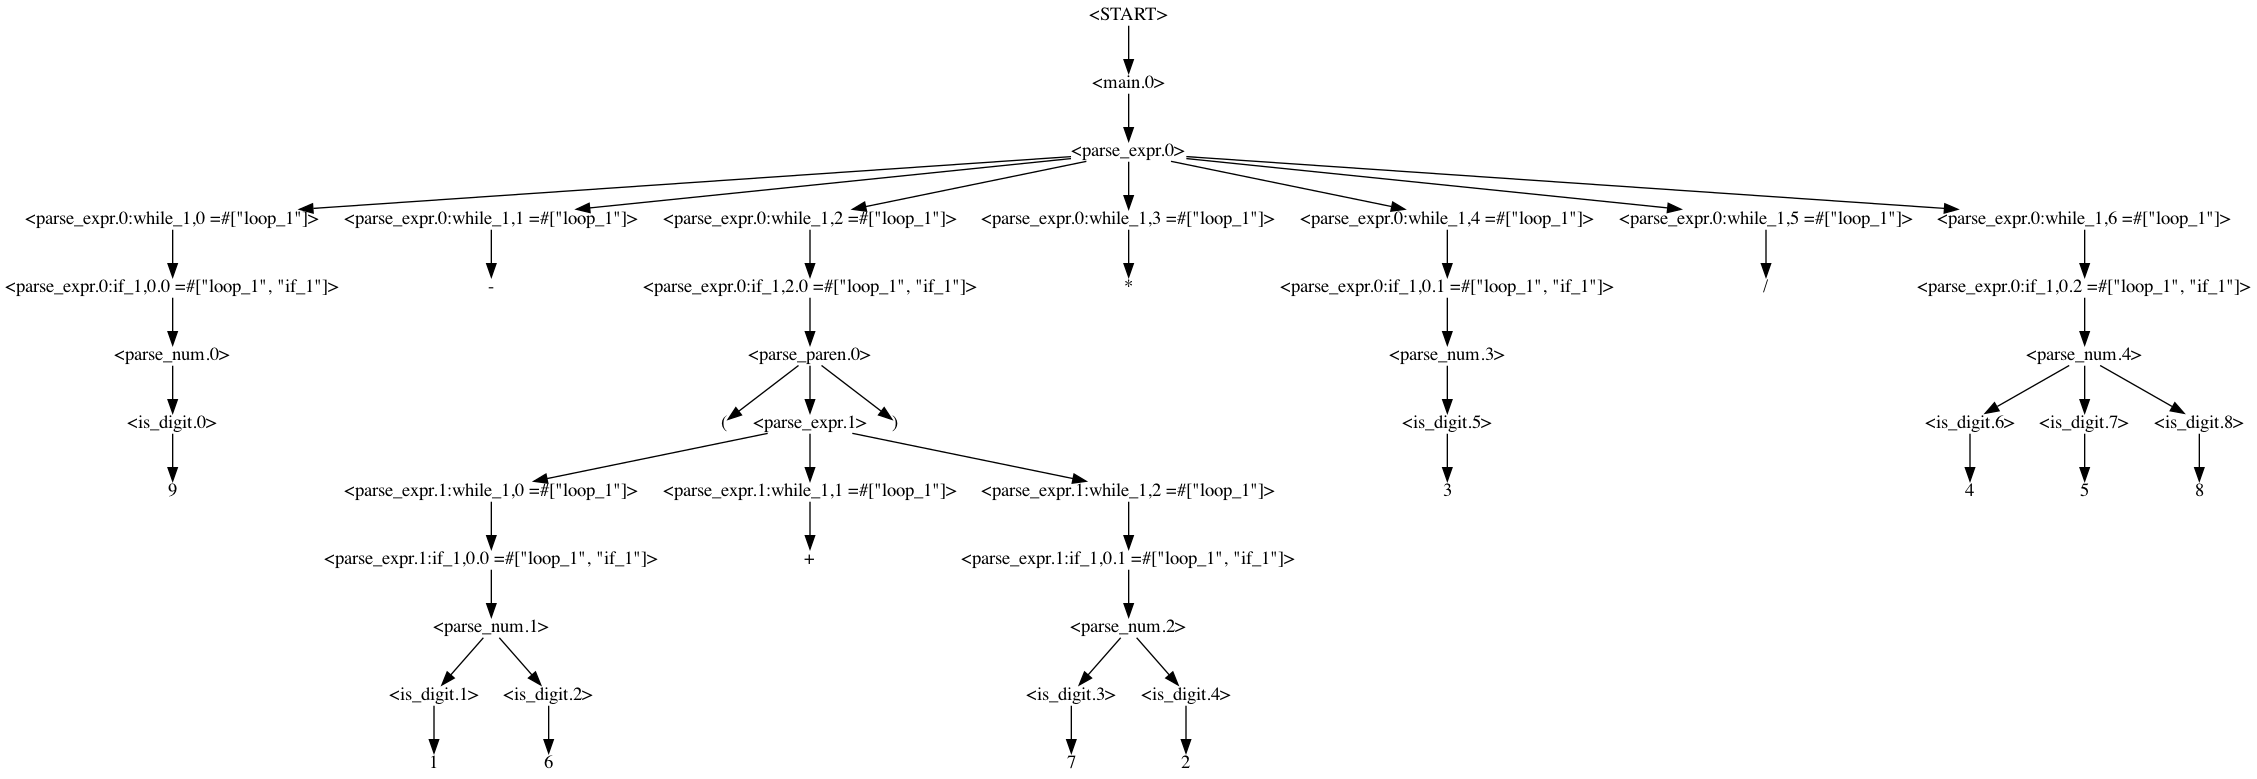

In [104]:
zoom(v:=utils.display_tree(lg_calc_trees[0]['tree']))

In [105]:
class DisplayTree3(DisplayTree):
    def extract_node(self, node, id):                                                      
        symbol, children, *annotation = node                                         
        return symbol, children, ''.join(str(a) for a in annotation)  

In [106]:
reset_generalizer()
generalized_calc_trees = generalize_loop_trees(mg_calc_trees)

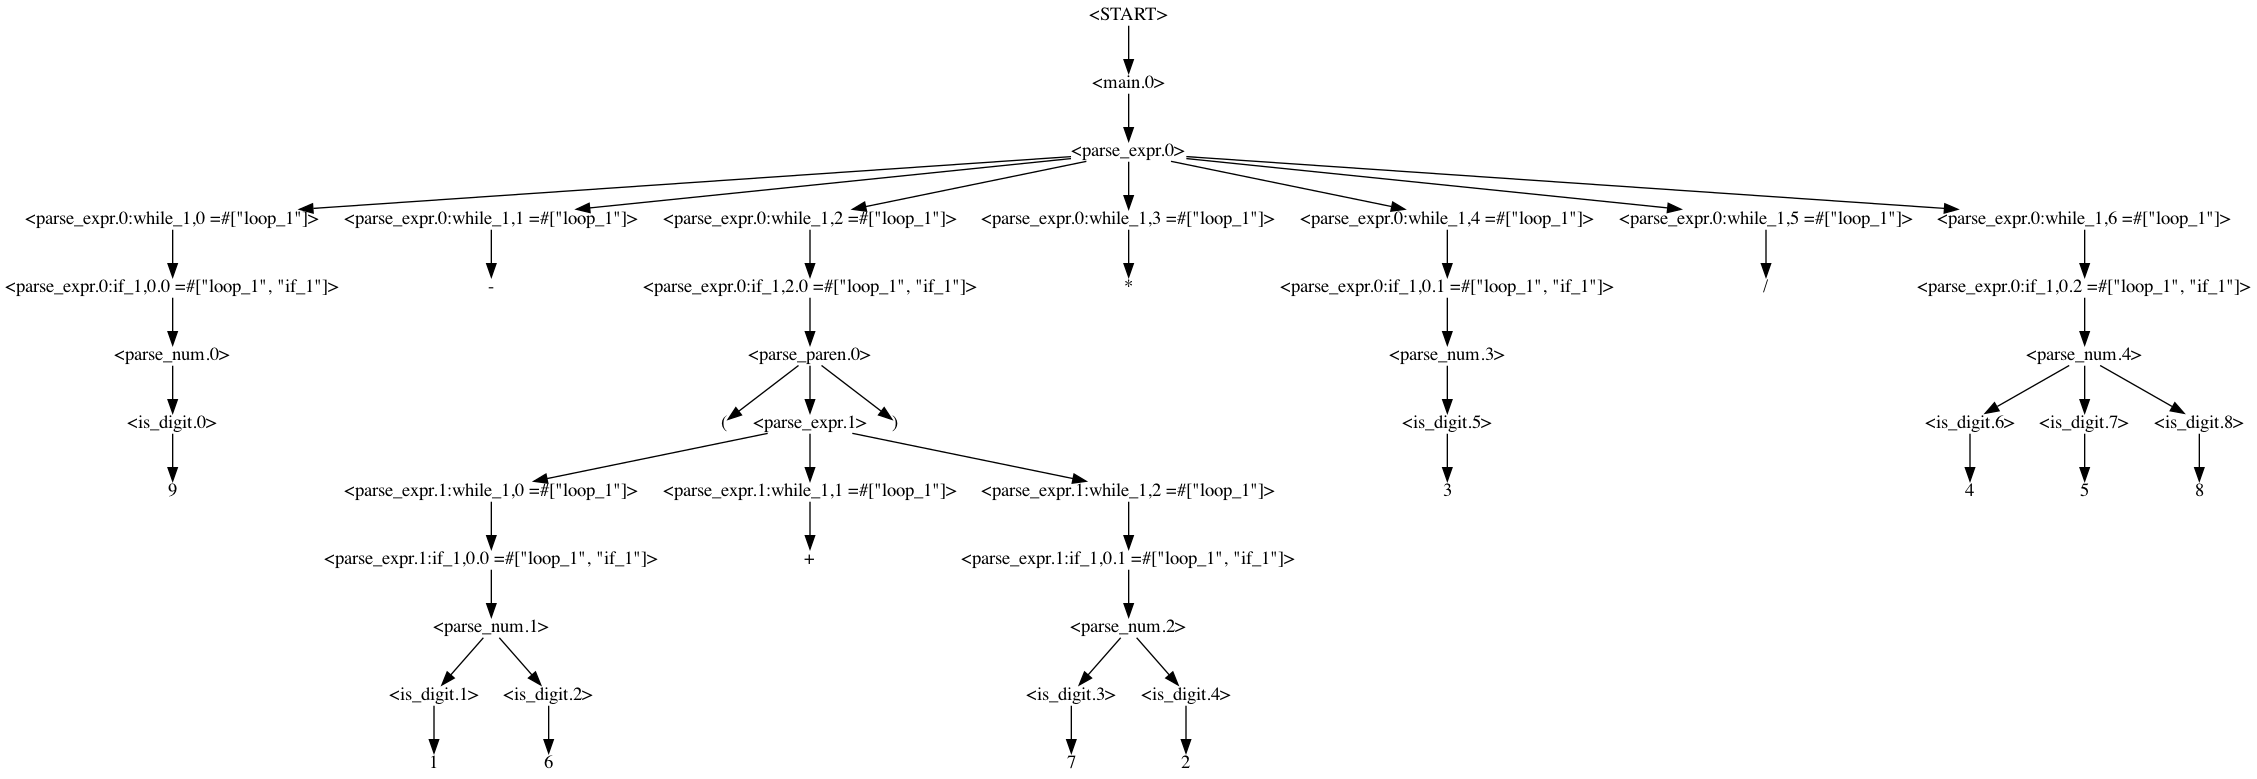

In [107]:
zoom(DisplayTree3(generalized_calc_trees[0]['tree']).display())

## Generating a Grammar

Generating a grammar from the generalized derivation trees is pretty simple. Start at the start node, and any node that represents a method or a pseudo method becomes a nonterminal. The children forms alternate expansions for the nonterminal. Since all the keys are compatible, merging the grammar is simply merging the hash map.

First, we define a pretty printer for grammar.

In [108]:
import re
RE_NONTERMINAL = re.compile(r'(<[^<> ]*>)')

In [109]:
def recurse_grammar(grammar, key, order, canonical):
    rules = sorted(grammar[key])
    old_len = len(order)
    for rule in rules:
        if not canonical:
            res =  re.findall(RE_NONTERMINAL, rule)
        else:
            res = rule
        for token in res:
            if token.startswith('<') and token.endswith('>'):
                if token not in order:
                    order.append(token)
    new = order[old_len:]
    for ckey in new:
        recurse_grammar(grammar, ckey, order, canonical)

In [110]:
def show_grammar(grammar, start_symbol='<START>', canonical=True):
    order = [start_symbol]
    recurse_grammar(grammar, start_symbol, order, canonical)
    if len(order) != len(grammar.keys()):
        assert len(order) < len(grammar.keys())
    return {k: sorted(grammar[k]) for k in order}

### Trees to grammar

In [111]:
def to_grammar(tree, grammar):
    node, children, _, _ = tree
    if not children: return grammar
    tokens = []
    if node not in grammar:
        grammar[node] = list()
    for c in children:
        tokens.append(c[0])
        to_grammar(c, grammar)
    grammar[node].append(tuple(tokens))
    return grammar

In [112]:
def merge_grammar(g1, g2):
    all_keys = set(list(g1.keys()) + list(g2.keys()))
    merged = {}
    for k in all_keys:
        alts = set(g1.get(k, []) + g2.get(k, []))
        merged[k] = alts
    return {k:[l for l in merged[k]] for k in merged}

In [113]:
def convert_to_grammar(my_trees):
    grammar = {}
    ret = []
    for my_tree in my_trees:
        tree = my_tree['tree']
        start = tree[0]
        src_file = my_tree['original']
        arg_file = my_tree['arg']
        ret.append((start, src_file, arg_file))
        g = to_grammar(tree, grammar)
        grammar = merge_grammar(grammar, g)
    return grammar

In [114]:
calc_grammar = convert_to_grammar(generalized_calc_trees)
show_grammar(calc_grammar)

{'<START>': [('<main.0>',), ('<main.1>',), ('<main.2>',)],
 '<main.0>': [('<parse_expr.0>',)],
 '<main.1>': [('<parse_expr.2>',)],
 '<main.2>': [('<parse_expr.4>',)],
 '<parse_expr.0>': [('<parse_expr.0:while_1,0 =#["loop_1"]>',
   '<parse_expr.0:while_1,1 =#["loop_1"]>',
   '<parse_expr.0:while_1,2 =#["loop_1"]>',
   '<parse_expr.0:while_1,3 =#["loop_1"]>',
   '<parse_expr.0:while_1,4 =#["loop_1"]>',
   '<parse_expr.0:while_1,5 =#["loop_1"]>',
   '<parse_expr.0:while_1,6 =#["loop_1"]>')],
 '<parse_expr.0:while_1,0 =#["loop_1"]>': [('<parse_expr.0:if_1,0.0 =#["loop_1", "if_1"]>',)],
 '<parse_expr.0:while_1,1 =#["loop_1"]>': [('-',)],
 '<parse_expr.0:while_1,2 =#["loop_1"]>': [('<parse_expr.0:if_1,2.0 =#["loop_1", "if_1"]>',)],
 '<parse_expr.0:while_1,3 =#["loop_1"]>': [('*',)],
 '<parse_expr.0:while_1,4 =#["loop_1"]>': [('<parse_expr.0:if_1,0.1 =#["loop_1", "if_1"]>',)],
 '<parse_expr.0:while_1,5 =#["loop_1"]>': [('/',)],
 '<parse_expr.0:while_1,6 =#["loop_1"]>': [('<parse_expr.0:if_1,

In [115]:
import ipynb.fs.full.x0_1_GrammarFuzzer as limitfuzzer

In [116]:
gf = limitfuzzer.LimitFuzzer(calc_grammar)
for i in range(10):
    print(gf.fuzz(key='<START>'))

(9)+3/4/58
(9)+3/4/58
8*3/40
9-(16+72)*3/458
8*3/40
9-(16+72)*3/458
(9)+3/4/58
8*3/40
9-(16+72)*3/458
9-(16+72)*3/458


### Inserting Empty Alternatives for IF and Loops

Next, we want to insert empty rules for those loops and conditionals that can be skipped. For loops, the entire sequence has to contain the empty marker.

In [117]:
def check_empty_rules(grammar):
    new_grammar = {}
    for k in grammar:
        if k in ':if_':
            name, marker = k.split('#')
            if name.endswith(' *'):
                new_grammar[k] = grammar[k].add(('',))
            else:
                new_grammar[k] = grammar[k]
        elif k in ':while_':
            # TODO -- we have to check the rules for sequences of whiles.
            # for now, ignore.
            new_grammar[k] = grammar[k]
        else:
            new_grammar[k] = grammar[k]
    return new_grammar

In [118]:
ne_calc_grammar = check_empty_rules(calc_grammar)
show_grammar(ne_calc_grammar)

{'<START>': [('<main.0>',), ('<main.1>',), ('<main.2>',)],
 '<main.0>': [('<parse_expr.0>',)],
 '<main.1>': [('<parse_expr.2>',)],
 '<main.2>': [('<parse_expr.4>',)],
 '<parse_expr.0>': [('<parse_expr.0:while_1,0 =#["loop_1"]>',
   '<parse_expr.0:while_1,1 =#["loop_1"]>',
   '<parse_expr.0:while_1,2 =#["loop_1"]>',
   '<parse_expr.0:while_1,3 =#["loop_1"]>',
   '<parse_expr.0:while_1,4 =#["loop_1"]>',
   '<parse_expr.0:while_1,5 =#["loop_1"]>',
   '<parse_expr.0:while_1,6 =#["loop_1"]>')],
 '<parse_expr.0:while_1,0 =#["loop_1"]>': [('<parse_expr.0:if_1,0.0 =#["loop_1", "if_1"]>',)],
 '<parse_expr.0:while_1,1 =#["loop_1"]>': [('-',)],
 '<parse_expr.0:while_1,2 =#["loop_1"]>': [('<parse_expr.0:if_1,2.0 =#["loop_1", "if_1"]>',)],
 '<parse_expr.0:while_1,3 =#["loop_1"]>': [('*',)],
 '<parse_expr.0:while_1,4 =#["loop_1"]>': [('<parse_expr.0:if_1,0.1 =#["loop_1", "if_1"]>',)],
 '<parse_expr.0:while_1,5 =#["loop_1"]>': [('/',)],
 '<parse_expr.0:while_1,6 =#["loop_1"]>': [('<parse_expr.0:if_1,

In [119]:
gf = limitfuzzer.LimitFuzzer(ne_calc_grammar)
for i in range(10):
    print(repr(gf.fuzz(key='<START>')))

'9-(16+72)*3/458'
'(9)+3/4/58'
'9-(16+72)*3/458'
'(9)+3/4/58'
'(9)+3/4/58'
'(9)+3/4/58'
'(9)+3/4/58'
'8*3/40'
'9-(16+72)*3/458'
'9-(16+72)*3/458'


### Learning Regular Expressions

We now need to generalize the loops. The idea is to look for patterns exclusively in the similarly named while loops using any of the regular expression learners. For the prototype, we replaced the modified Sequitur with the modified Fernau which gave us better regular expressions than before. The main constraint we have is that we want to avoid repeated execution of program if possible. Fernau algorithm can recover a reasonably approximate regular exression based only on positive data.

#### The modified Fernau algorithm

The Fernau algorithm is from _Algorithms for learning regular expressions from positive data_ by _HenningFernau_. Our algorithm uses a modified form of the Prefix-Tree-Acceptor from Fernau. First we define an LRF buffer of a given size.

In [120]:
class Buf:
    def __init__(self, size):
        self.size = size
        self.items = [None] * self.size

The `add1()` takes in an array, and transfers the first element of the array into the end of current buffer, and simultaneously drops the first element of the buffer.

In [121]:
class Buf(Buf):
    def add1(self, items):
        self.items.append(items.pop(0))
        return self.items.pop(0)

For equality between the buffer and an array, we only compare when both the array and the items are actually elements and not chunked arrays.

In [122]:
class Buf(Buf):
    def __eq__(self, items):
        if any(isinstance(i, dict) for i in self.items): return False
        if any(isinstance(i, dict) for i in items): return False
        return items == self.items

The `detect_chunks()` detects any repeating portions of a list of `n` size.

In [123]:
def detect_chunks(n, lst_):
    lst = list(lst_)
    chunks = set()
    last = Buf(n)
    # check if the next_n elements are repeated.
    for _ in range(len(lst) - n):
        lnext_n = lst[0:n]
        if last == lnext_n:
            # found a repetition.
            chunks.add(tuple(last.items))
        else:
            pass
        last.add1(lst)
    return chunks

Once we have detected plausible repeating sequences, we gather all similar sequences into arrays.

In [124]:
def chunkify(lst_,n , chunks):
    lst = list(lst_)
    chunked_lst = []
    while len(lst) >= n:
        lnext_n = lst[0:n]
        if (not any(isinstance(i, dict) for i in lnext_n)) and tuple(lnext_n) in chunks:
            chunked_lst.append({'_':lnext_n})
            lst = lst[n:]
        else:
            chunked_lst.append(lst.pop(0))
    chunked_lst.extend(lst)
    return chunked_lst

The `identify_chunks()` simply calls the `detect_chunks()` on all given lists, and then converts all chunks identified into arrays.

In [125]:
def identify_chunks(my_lsts):
    # initialize
    all_chunks = {}
    maximum = max(len(lst) for lst in my_lsts)
    for i in range(1, maximum//2+1):
        all_chunks[i] = set()

    # First, identify chunks in each list.
    for lst in my_lsts:
        for i in range(1,maximum//2+1):
            chunks = detect_chunks(i, lst)
            all_chunks[i] |= chunks

    # Then, chunkify
    new_lsts = []
    for lst in my_lsts:
        for i in range(1,maximum//2+1):
            chunks = all_chunks[i]
            lst = chunkify(lst, i, chunks)
        new_lsts.append(lst)
    return new_lsts

##### Prefix tree acceptor

The prefix tree acceptor is a way to represent positive data. The `Node` class holds a single node in the prefix tree acceptor.

In [126]:
class Node:
    # Each tree node gets its unique id.
    _uid = 0
    def __init__(self, item):
        # self.repeats = False
        self.count = 1 # how many repetitions.
        self.counters = set()
        self.last = False
        self.children = []
        self.item = item
        self.uid = Node._uid
        Node._uid += 1

    def update_counters(self):
        self.counters.add(self.count)
        self.count = 0
        for c in self.children:
            c.update_counters()

    def __repr__(self):
        return str(self.to_json())

    def __str__(self):
        return str("(%s, [%s])", (self.item, ' '.join([str(i) for i in self.children])))

    def to_json(self):
        s = ("(%s)" % ' '.join(self.item['_'])) if isinstance(self.item, dict) else str(self.item)
        return (s, tuple(self.counters), [i.to_json() for i in self.children])

    def inc_count(self):
        self.count += 1

    def add_ref(self):
        self.count = 1

    def get_child(self, c):
        for i in self.children:
            if i.item == c: return i
        return None

    def add_child(self, c):
        # first check if it is the current node. If it is, increment
        # count, and return ourselves.
        if c == self.item:
            self.inc_count()
            return self
        else:
            # check if it is one of the children. If it is a child, then
            # preserve its original count.
            nc = self.get_child(c)
            if nc is None:
                nc = Node(c)
                self.children.append(nc)
            else:
                nc.add_ref()
            return nc

The `update_tree()` essentially transforms a list of nodes to a chain of nodes starting at `root` if the `root` is an empty tree. If the `root` already contains a tree, the `update_tree()` traverses the path represented by `lst_` and makes a new child branch where the path specified doesn't exist in the tree.

In [127]:
def update_tree(lst_, root):
    lst = list(lst_)
    branch = root
    while lst:
        first, *lst = lst
        branch = branch.add_child(first)
    branch.last = True
    return root

Given a number of lists, the `create_tree_with_lists()` creates an actual tree out of these lists.

In [128]:
def create_tree_with_lsts(lsts):
    Node._uid = 0
    root =  Node(None)
    for lst in lsts:
        root.count = 1 # there is at least one element.
        update_tree(lst, root)
        root.update_counters()
    return root

Given a node, and a key, return the key and alts as a dict.

In [129]:
def get_star(node, key):
    if node.item is None:
        return [], {}
    if isinstance(node.item, dict):
        # take care of counters
        elements = node.item['_']
        my_key = "<%s-%d-s>" % (key, node.uid)
        alts = [elements]
        if len(node.counters) > 1: # repetition
            alts.append(elements + [my_key])
        return [my_key], {my_key:alts}
    else:
        return [str(node.item)], {}

In [130]:
def node_to_grammar(node, grammar, key):
    rule = []
    alts = [rule]
    if node.uid == 0:
        my_key = "<%s>" % key
    else:
        my_key = "<%s-%d>" % (key, node.uid)
    grammar[my_key] = alts
    if node.item is not None:
        mk, g = get_star(node, key)
        rule.extend(mk)
        grammar.update(g)
    # is the node last?
    if node.last:
        assert node.item is not None
        # add a duplicate rule that ends here.
        ending_rule = list(rule)
        # if there are no children, the current rule is
        # any way ending.
        if node.children:
            alts.append(ending_rule)

    if node.children:
        if len(node.children) > 1:
            my_ckey = "<%s-%d-c>" % (key, node.uid)
            rule.append(my_ckey)
            grammar[my_ckey] = [ ["<%s-%d>" % (key, c.uid)] for c in node.children]
        else:
            my_ckey = "<%s-%d>" % (key, node.children[0].uid)
            rule.append(my_ckey)
    else:
        pass
    for c in node.children:
        node_to_grammar(c, grammar, key)
    return grammar

def generate_grammar(lists, key):
    lsts = identify_chunks(lists)
    tree = create_tree_with_lsts(lsts)
    grammar = {}
    node_to_grammar(tree, grammar, key)
    return grammar

Given a rule, determine the abstraction for it.

In [131]:
def collapse_alts(rules, k):
    ss = [[str(r) for r in rule] for rule in rules]
    x = generate_grammar(ss, k[1:-1])
    return x

In [132]:
def collapse_rules(grammar):
    r_grammar = {}
    for k in grammar:
        new_grammar = collapse_alts(grammar[k], k)
        # merge the new_grammar with r_grammar
        # we know none of the keys exist in r_grammar because
        # new keys are k prefixed.
        for k_ in new_grammar:
            r_grammar[k_] = new_grammar[k_]
    return r_grammar

In [133]:
collapsed_calc_grammar = collapse_rules(ne_calc_grammar)
show_grammar(collapsed_calc_grammar)

{'<START>': [['<START-0-c>']],
 '<START-0-c>': [['<START-1>'], ['<START-2>'], ['<START-3>']],
 '<START-1>': [['<main.0>']],
 '<START-2>': [['<main.1>']],
 '<START-3>': [['<main.2>']],
 '<main.0>': [['<main.0-1>']],
 '<main.0-1>': [['<parse_expr.0>']],
 '<parse_expr.0>': [['<parse_expr.0-1>']],
 '<parse_expr.0-1>': [['<parse_expr.0:while_1,0 =#["loop_1"]>',
   '<parse_expr.0-2>']],
 '<parse_expr.0:while_1,0 =#["loop_1"]>': [['<parse_expr.0:while_1,0 =#["loop_1"]-1>']],
 '<parse_expr.0-2>': [['<parse_expr.0:while_1,1 =#["loop_1"]>',
   '<parse_expr.0-3>']],
 '<parse_expr.0:while_1,0 =#["loop_1"]-1>': [['<parse_expr.0:if_1,0.0 =#["loop_1", "if_1"]>']],
 '<parse_expr.0:if_1,0.0 =#["loop_1", "if_1"]>': [['<parse_expr.0:if_1,0.0 =#["loop_1", "if_1"]-1>']],
 '<parse_expr.0:if_1,0.0 =#["loop_1", "if_1"]-1>': [['<parse_num.0>']],
 '<parse_num.0>': [['<parse_num.0-1>']],
 '<parse_num.0-1>': [['<is_digit.0>']],
 '<is_digit.0>': [['<is_digit.0-1>']],
 '<is_digit.0-1>': [['9']],
 '<parse_expr.0:whi

In [134]:
gf = limitfuzzer.LimitFuzzer(collapsed_calc_grammar)
for i in range(10):
    print(gf.fuzz(key='<START>'))

(9)+3/4/58
(9)+3/4/58
(9)+3/4/58
(9)+3/4/58
9-(16+72)*3/458
8*3/40
8*3/40
(9)+3/4/58
(9)+3/4/58
9-(16+72)*3/458


In [135]:
def convert_spaces_in_keys(grammar):
    keys = {key: key.replace(' ', '_') for key in grammar}
    new_grammar = {}
    for key in grammar:
        new_alt = []
        for rule in grammar[key]:
            new_rule = []
            for t in rule:
                for k in keys:
                    t = t.replace(k, keys[k])
                new_rule.append(t)
            new_alt.append(new_rule)
        new_grammar[keys[key]] = new_alt
    return new_grammar

In [136]:
calc_grammar = convert_spaces_in_keys(collapsed_calc_grammar)
show_grammar(calc_grammar, canonical=True)

{'<START>': [['<START-0-c>']],
 '<START-0-c>': [['<START-1>'], ['<START-2>'], ['<START-3>']],
 '<START-1>': [['<main.0>']],
 '<START-2>': [['<main.1>']],
 '<START-3>': [['<main.2>']],
 '<main.0>': [['<main.0-1>']],
 '<main.0-1>': [['<parse_expr.0>']],
 '<parse_expr.0>': [['<parse_expr.0-1>']],
 '<parse_expr.0-1>': [['<parse_expr.0:while_1,0_=#["loop_1"]>',
   '<parse_expr.0-2>']],
 '<parse_expr.0:while_1,0_=#["loop_1"]>': [['<parse_expr.0:while_1,0_=#["loop_1"]-1>']],
 '<parse_expr.0-2>': [['<parse_expr.0:while_1,1_=#["loop_1"]>',
   '<parse_expr.0-3>']],
 '<parse_expr.0:while_1,0_=#["loop_1"]-1>': [['<parse_expr.0:if_1,0.0_=#["loop_1",_"if_1"]>']],
 '<parse_expr.0:if_1,0.0_=#["loop_1",_"if_1"]>': [['<parse_expr.0:if_1,0.0_=#["loop_1",_"if_1"]-1>']],
 '<parse_expr.0:if_1,0.0_=#["loop_1",_"if_1"]-1>': [['<parse_num.0>']],
 '<parse_num.0>': [['<parse_num.0-1>']],
 '<parse_num.0-1>': [['<is_digit.0>']],
 '<is_digit.0>': [['<is_digit.0-1>']],
 '<is_digit.0-1>': [['9']],
 '<parse_expr.0:whi

In [137]:
gf = limitfuzzer.LimitFuzzer(calc_grammar)

In [138]:
for i in range(10):
    print(gf.fuzz(key='<START>'))

9-(16+72)*3/458
8*3/40
(9)+3/4/58
(9)+3/4/58
9-(16+72)*3/458
8*3/40
(9)+3/4/58
8*3/40
8*3/40
9-(16+72)*3/458


### Remove duplicate and redundant entries

In [139]:
def first_in_chain(token, chain):
    while True:
        if token in chain:
            token = chain[token]
            assert isinstance(token, str)
        else:
            break
    return token

Return a new symbol for `grammar` based on `symbol_name`.

In [140]:
def new_symbol(grammar, symbol_name="<symbol>"):
    if symbol_name not in grammar:
        return symbol_name

    count = 1
    while True:
        tentative_symbol_name = symbol_name[:-1] + "-" + repr(count) + ">"
        if tentative_symbol_name not in grammar:
            return tentative_symbol_name
        count += 1

Replace keys that have a single token definition with the token in the defition.

In [141]:
def replacement_candidate_chains(grammar, ignores):
    to_replace = {}
    for k in grammar:
        if k in ignores: continue
        if len(grammar[k]) != 1: continue
        rule = grammar[k][0]
        if len(rule) != 1: continue
        if utils.is_nt(rule[0]):
            to_replace[k] = rule[0]
        else:
            pass
    return to_replace

In [142]:
def replace_key_by_new_key(grammar, keys_to_replace):
    new_grammar = {}
    for key in grammar:
        new_rules = []
        for rule in grammar[key]:
            new_rule = [keys_to_replace.get(token, token)
                        for token in rule]
            new_rules.append(new_rule)
        new_grammar[keys_to_replace.get(key, key)] = new_rules
    assert len(grammar) == len(new_grammar)
    return new_grammar

In [143]:
def replace_key_by_key(grammar, keys_to_replace):
    new_grammar = {}
    for key in grammar:
        if key in keys_to_replace: continue
        new_rules = []
        for rule in grammar[key]:
            for t in rule:
                assert isinstance(t, str)
            new_rule = [first_in_chain(token, keys_to_replace) for token in rule]
            new_rules.append(new_rule)
        new_grammar[key] = new_rules
    return new_grammar

In [144]:
def remove_single_entries(grammar):
    keys_to_replace = replacement_candidate_chains(grammar, {start_symbol, '<main>'})
    return replace_key_by_key(grammar, keys_to_replace)

Remove keys that have similar rules.

In [145]:
def collect_duplicate_rule_keys(grammar):
    collect = {}
    for k in grammar:
        salt = str(sorted(grammar[k]))
        if salt not in collect:
            collect[salt] = (k, set())
        else:
            collect[salt][1].add(k)
    return collect

In [146]:
def remove_duplicate_rule_keys(grammar):
    g = grammar
    while True:
        collect = collect_duplicate_rule_keys(g)
        keys_to_replace = {}
        for salt in collect:
            k, st = collect[salt]
            for s in st:
                keys_to_replace[s] = k
        if not keys_to_replace:
            break
        g = replace_key_by_key(g, keys_to_replace)
    return g

Remove all the control flow vestiges from names, and simply name them sequentially.

In [147]:
def collect_replacement_keys(grammar):
    g = utils.deep_copy(grammar)
    to_replace = {}
    for k in grammar:
        if ':' in k:
            first, rest = k.split(':')
            sym = new_symbol(g, symbol_name=first + '>')
            assert sym not in g
            g[sym] = None
            to_replace[k] = sym
        else:
            continue
    return to_replace

Remove keys that are referred to only from a single rule, and which have a single alternative.
Import. This can't work on canonical representation. First, given a key, we figure out its distance to `<START>`.

This is different from `remove_single_entries()` in that, there we do not care if the key is being used multiple times. Here, we only replace keys that are referred to only once.

In [148]:
import math

In [149]:
def len_to_start(item, parents, start_symbol, seen=None):
    if seen is None: seen = set()
    if item in seen: return math.inf
    seen.add(item)
    if item == start_symbol: return 0
    else: return 1 + min(len_to_start(p, parents, start_symbol, seen)
                         for p in parents[item])

In [150]:
def order_by_length_to_start(items, parent_map, start_symbol):
    return sorted(items, key=lambda i: len_to_start(i, parent_map, start_symbol))

Next, we generate a map of `child -> [parents]`.

In [151]:
def get_parents_of_tokens(grammar, key, seen=None, parents=None):
    if parents is None: parents, seen = {}, set()
    if key in seen: return parents
    seen.add(key)
    for res in grammar[key]:
        for token in res:
            if not utils.is_nt(token): continue
            parents.setdefault(token, []).append(key)
    for ckey in {i for i in  grammar if i not in seen}:
        get_parents_of_tokens(grammar, ckey, seen, parents)
    return parents

In [152]:
def remove_references(keys_to_replace):
    to_process = list(keys_to_replace.keys())
    updated_dict = {}
    references = {}
    order = []
    while to_process:
        key, *to_process = to_process
        rule = keys_to_replace[key]
        new_rule = []
        skip = False
        for token in rule:
            if token not in updated_dict:
                if token in to_process:
                    # so this token will get defined later. We simply postpone
                    # the processing of this key until that key is defined.
                    # TODO: check for cycles.
                    to_process.append(key)
                    references.setdefault(token, set()).add(key)
                    skip = True
                    break
                else:
                    new_rule.append(token)
            else:
                new_rule.extend(updated_dict[token])
        if not skip:
            order.append(key)
            updated_dict[key] = new_rule
    return updated_dict

In [153]:
def replace_keys_by_rule(grammar, keys_to_replace):
    # we now need to verify that none of the keys are part of the sequences.
    keys_to_replace = remove_references(keys_to_replace)

    new_grammar = {}
    for key in grammar:
        if key in keys_to_replace: continue

        new_rules = []
        for rule in grammar[key]:
            new_rule = []
            for token in rule:
                if token in keys_to_replace:
                    new_rule.extend(keys_to_replace[token])
                else:
                    new_rule.append(token)
            new_rules.append(new_rule)
        new_grammar[key] = new_rules
    return new_grammar

Now, all together.

In [154]:
def remove_single_alts(grammar, start_symbol):
    single_alts = {p for p in grammar if len(grammar[p]) == 1 and p != start_symbol}

    child_parent_map = get_parents_of_tokens(grammar, start_symbol)
    assert len(child_parent_map) < len(grammar)

    single_refs = {p:child_parent_map[p] for p in single_alts if len(child_parent_map[p]) <= 1}

    ordered = order_by_length_to_start(single_refs, child_parent_map, start_symbol)

    for p in ordered:
        assert len(grammar[p]) == 1
        if not isinstance(grammar[p][0], str):
            print(p, grammar[p][0])

    keys_to_replace = {p:grammar[p][0] for p in ordered}
    g =  replace_keys_by_rule(grammar, keys_to_replace)
    return g

remove similar rules from under a single key

In [155]:
def len_rule(r): return len(r)
def len_definition(d): return sum([len_rule(r) for r in d])
def len_grammar(g): return sum([len_definition(g[k]) for k in g])

In [156]:
def remove_duplicate_rules_in_a_key(g):
    g_ = {}
    for k in g:
        s = {str(r):r for r in g[k]}
        g_[k] = list(sorted(list(s.values())))
    return g_

In [157]:
def grammar_gc(grammar, start_symbol):
    def strip_key(grammar, key, order):
        rules = sorted(grammar[key])
        old_len = len(order)
        for rule in rules:
            for token in rule:
                if utils.is_nt(token):
                    if token not in order:
                        order.append(token)
        new = order[old_len:]
        for ckey in new:
            strip_key(grammar, ckey, order)

    order = [start_symbol]
    strip_key(grammar, start_symbol, order)
    assert len(order) == len(grammar.keys())
    g = {k: sorted(grammar[k]) for k in order}
    for k in g:
        for r in g[k]:
            for t in r:
                assert isinstance(t, str)
    return g

In [158]:
def cleanup_grammar(g, start_symbol):
    g = grammar_gc(g, start_symbol)
    g1 = check_empty_rules(g) # add optional rules
    g1 = grammar_gc(g1, start_symbol)
 
    g2 = collapse_rules(g1) # learn regex
    g2 = grammar_gc(g2, start_symbol)

    g3 = convert_spaces_in_keys(g2) # fuzzable grammar
    g3 = grammar_gc(g3, start_symbol)
    return g3

In [159]:
def remove_single_entry_chains(grammar, start_symbol):
    keys_to_replace = replacement_candidate_chains(grammar, {start_symbol, '<main>'})
    return replace_key_by_key(grammar, keys_to_replace)

In [160]:
def cleanup_token_names(grammar):
    keys_to_replace = collect_replacement_keys(grammar)
    g = replace_key_by_new_key(grammar, keys_to_replace)
    return g

In [161]:
def remove_self_definitions(g):
    g_ = {}
    for k in g:
        rs_ = []
        for r in g[k]:
            assert not isinstance(r, str)
            if len(r) == 1 and r[0] == k: continue
            rs_.append(r)
        g_[k] = rs_
    return g_

In [162]:
def compact_grammar(e, start_symbol):
    assert start_symbol in e
    l = len_grammar(e)
    diff = 1
    while diff > 0:
        assert start_symbol in e
        e = remove_single_entry_chains(e, start_symbol)
        e = grammar_gc(e, start_symbol) # garbage collect

        e = remove_duplicate_rule_keys(e)
        e = grammar_gc(e, start_symbol) # garbage collect

        e = cleanup_token_names(e)
        e = grammar_gc(e, start_symbol) # garbage collect

        e = remove_single_alts(e, start_symbol)
        e = grammar_gc(e, start_symbol) # garbage collect

        e = remove_duplicate_rules_in_a_key(e)
        e = grammar_gc(e, start_symbol) # garbage collect

        e = remove_self_definitions(e)
        e = grammar_gc(e, start_symbol) # garbage collect

        l_ = len_grammar(e)
        diff = l - l_
        l = l_
    e = grammar_gc(e, start_symbol)
    return e

## Accio Grammar

In [163]:
import os
import hashlib

In [164]:
def accio_grammar(fname, src, samples, cache=True):
    hash_id = hashlib.md5(json.dumps(samples).encode()).hexdigest()
    cache_file = "build/%s_%s_generalized_tree.json" % (fname, hash_id)
    if os.path.exists(cache_file) and cache:
        with open(cache_file) as f:
            generalized_tree = json.load(f)
    else:
    # regenerate the program
        program_src[fname] = src
        with open('subjects/%s' % fname, 'w+') as f:
            print(src, file=f) 
        resrc = rewrite(src, fname)
        with open('build/%s' % fname, 'w+') as f:
            print(resrc, file=f)
        os.makedirs('samples/%s' % fname, exist_ok=True)
        sample_files = {("samples/%s/%d.csv"%(fname,i)):s for i,s in enumerate(samples)}
        for k in sample_files:
            with open(k, 'w+') as f:
                print(sample_files[k], file=f)

        call_trace = []
        for i in sample_files:
            thash_id = hashlib.md5(json.dumps(sample_files[i]).encode()).hexdigest()
            trace_cache_file = "build/%s_%s_trace.json" % (fname, thash_id)
            if os.path.exists(trace_cache_file) and cache:
                with open(trace_cache_file) as f:
                    my_tree = f.read()
            else:
                my_tree = utils.do("env PYTHONPATH='.:src:subjects' %s ./build/%s %s" 
                                   % (sys.executable, fname, i), shell=True).stdout
                with open(trace_cache_file, 'w+') as f:
                    print(my_tree, file=f)
            call_trace.append(json.loads(my_tree)[0])

        mined_tree = miner(call_trace)
        reset_generalizer()
        generalized_m_tree = generalize_method_trees(mined_tree)
        reset_generalizer()
        generalized_tree = generalize_loop_trees(generalized_m_tree)
        reset_generalizer()
        # costly data structure.
        with open(cache_file, 'w+') as f:
            json.dump(generalized_tree, f)
    g0 = convert_to_grammar(generalized_tree)
    with open('build/%s_grammar_0.json' % fname, 'w+') as f:
        json.dump(g0, f)
    assert '<START>' in g0
    g = cleanup_grammar(g0, start_symbol='<START>')
    with open('build/%s_grammar_first.json' % fname, 'w+') as f:
        json.dump(g, f)
    g = compact_grammar(g, start_symbol='<START>')
    with open('build/%s_grammar.json' % fname, 'w+') as f:
        json.dump(g, f)
    return show_grammar(g)

In [165]:
calc_grammar = accio_grammar('calculator.py', program_src['calculator.py'],
                             ['(1+2)-2',
                              '11',
                              '3*5-22/3',
                             '243+22*(112/990)'])

<parse_expr.3-1> ['<is_digit.2-1>', '<parse_expr.3-2>']
<parse_expr.4-1> ['<parse_num.6-1>', '<parse_expr.4-2>']
<parse_expr.0-1> ['<parse_paren.0-1>', '<parse_expr.0-2>']
<parse_expr.4-2> ['<parse_expr.1>', '<parse_expr.4-3>']
<parse_num.6-1> ['<is_digit.1-1>', '<parse_num.6-2>']
<parse_expr.3-2> ['<parse_expr.3>', '<parse_expr.3-3>']
<parse_paren.0-1> ['(', '<parse_paren.0-2>']
<parse_expr.0-2> ['<parse_expr.0>', '<is_digit.1-1>']
<parse_num.6-2> ['<is_digit.4-1>', '<is_digit.2-1>']
<parse_paren.0-2> ['<parse_expr.1-1>', '<parse_paren.0-3>']
<parse_expr.3-3> ['<is_digit.3-1>', '<parse_expr.3-4>']
<parse_expr.4-3> ['<is_digit.1-1>', '<parse_expr.4-4>']
<is_digit.3-1> ['5']
<parse_expr.3-4> ['<parse_expr.0>', '<parse_expr.3-5>']
<parse_expr.1-1> ['<is_digit.0-1>', '<parse_expr.1-2>']
<parse_expr.4-4> ['<parse_expr.3>', '<parse_paren.1-1>']
<is_digit.4-1> ['4']
<parse_expr.1-2> ['<parse_expr.1>', '<is_digit.1-1>']
<parse_expr.3-5> ['<is_digit.1-1>', '<parse_expr.3-6>']
<parse_paren.1-1>

In [166]:
print(calc_grammar.keys())
utils.display_grammar(calc_grammar, '<START>')

dict_keys(['<START>', '<START-0-c>', '<is_digit.0-1>', '<parse_expr.1>', '<is_digit.1-1>', '<parse_paren.0-3>', '<parse_expr.0>', '<is_digit.2-1>', '<parse_expr.3>', '<parse_expr.3-7>'])


NameError: name 'is_not' is not defined

In [ ]:
gf = limitfuzzer.LimitFuzzer(calc_grammar)

In [ ]:
for i in range(10):
    print(gf.fuzz(key='<START>'))

# Done

In [ ]:
#%tb